In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import kats
import torch
import torch.nn as nn

from kats.consts import TimeSeriesData
from kats.detectors.outlier import OutlierDetector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from torch.autograd import Variable

# Data Analysis and Processing

## Data loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

dataPath = 'drive/My Drive/Colab Notebooks/Datasets/'

Mounted at /content/drive


### Wind farm information

In [5]:
# Reading Turbine power Curves
turbine_1_power = pd.read_csv (r''+dataPath+'/Case1/Turbine_Info/Power_Curve.txt', header=0, delim_whitespace=True)
turbine_2_power = pd.read_csv (r''+dataPath+'/Case2/Turbine_Info/Power_Curve.txt', header=0, delim_whitespace=True)
turbine_3_power = pd.read_csv (r''+dataPath+'/Case3/Turbine_Info/Power_Curve.txt', header=0, delim_whitespace=True)

# Renaming of the headers
turbine_1_power = turbine_1_power.rename(columns={ turbine_1_power.columns[0]: 'Case1 Turbine'})
turbine_2_power = turbine_2_power.rename(columns={ turbine_2_power.columns[0]: 'Case2 Turbine'})
turbine_3_power = turbine_3_power.rename(columns={ turbine_3_power.columns[0]: 'Case3 Turbine'})

# Concatenation the Turbines to 1 dataframe
all_turbines_power_curve_dataframe = pd.concat([turbine_1_power, turbine_2_power,turbine_3_power ], axis=1)

# Interpolation for the missing values
all_turbines_power_curve_dataframe.interpolate(inplace=True)

# Renaming ofthe the index column
all_turbines_power_curve_dataframe.index.name = 'Wind Speed'
print( all_turbines_power_curve_dataframe )

            Case1 Turbine  Case2 Turbine  Case3 Turbine
Wind Speed                                             
3.0                 12.30        4.52981          21.70
3.5                 24.60       36.96220          56.60
4.0                 36.90       73.13270          91.50
4.5                 79.55      117.56100         143.70
5.0                122.20      166.71600         195.90
5.5                177.60      228.79400         272.35
6.0                233.00      303.82100         348.80
6.5                311.05      391.37400         455.60
7.0                389.10      495.37900         562.40
7.5                493.10      618.06200         704.20
8.0                597.10      759.14900         846.00
8.5                729.45      911.89800        1009.85
9.0                861.80     1077.04000        1173.70
9.5               1013.90     1244.10000        1336.85
10.0              1166.00     1410.75000        1500.00
10.5              1330.70     1500.61000        

In [6]:
# Reading Turbine info
turbine_1_info = pd.read_csv (r''+dataPath+'/Case1/Turbine_Info/Info.txt', header=None, delimiter=":", names =['Name', 'val'] )
turbine_2_info = pd.read_csv (r''+dataPath+'/Case2/Turbine_Info/Info.txt', header=None, delimiter=":", names =['Name', 'val'])
turbine_3_info = pd.read_csv (r''+dataPath+'/Case3/Turbine_Info/Info.txt', header=None, delimiter=":", names =['Name', 'val'])

#Creation of the lists
col_one_list = turbine_1_info.iloc[: , 0].tolist()
turbine_1_info = turbine_1_info.iloc[: , 1].tolist()
turbine_2_info = turbine_2_info.iloc[: , 1].tolist()
turbine_3_info = turbine_3_info.iloc[: , 1].tolist()
table = tuple(zip(*list(zip(turbine_1_info, turbine_2_info, turbine_3_info))))

# Concatenation the Turbines to 1 dataframe
all_turbines_info_dataframe = pd.DataFrame( (table) ,columns =col_one_list )
#Increment of the indexing
all_turbines_info_dataframe.index += 1 

print( all_turbines_info_dataframe)

  Rated Power Hub Height Blade Length
1      1500KW        65m        38.5m
2      1500KW        65m        38.5m
3      1500KW        80m          43m


### Measurement data

In [7]:
# Reading the measurements
measurement_case_1 = pd.read_csv (r''+dataPath+'/Case1/Proj_Measurements_Case1.csv', header=0)
measurement_case_2 = pd.read_csv (r''+dataPath+'/Case2/Proj_Measurements_Case2.csv', header=0)
measurement_case_3 = pd.read_csv (r''+dataPath+'/Case3/Proj_Measurements_Case3.csv', header=0)

# Set indexing to the Date_time
measurement_case_1['Date_Time']= pd.to_datetime(measurement_case_1['Date_Time'])
measurement_case_2['Date_Time']= pd.to_datetime(measurement_case_2['Date_Time'])
measurement_case_3['Date_Time']= pd.to_datetime(measurement_case_3['Date_Time'])

measurement_case_1.head()

,Date_Time,Speed_10m,Direction_10m,Speed_30m,Direction_30m,Speed_65m,Direction_65m,Speed_70m,Direction_70m,Speed_80m,Direction_80m,Park Power [KW]
0,2017-01-07 20:15:00,2.950,96.4,1.800,89.6,3.300,200.0,3.400,187.1,0.0,0.0,NaN
1,2017-01-07 20:30:00,2.967,91.3,3.033,77.1,2.467,194.5,2.833,178.6,0.0,0.0,NaN
2,2017-01-07 20:45:00,3.167,86.1,2.667,65.3,1.767,178.8,2.067,160.7,0.0,0.0,NaN
3,2017-01-07 21:00:00,3.300,85.5,2.800,58.5,1.600,176.0,1.750,157.5,0.0,0.0,NaN
4,2017-01-07 21:15:00,3.300,85.5,2.800,58.5,1.600,176.0,1.750,157.6,0.0,0.0,NaN


### NWP data

In [8]:
# Reading the NWP data
nwp_case_1 = pd.read_csv (r''+dataPath+'/Case1/Proj_NWP_Case1.csv', header=0)
nwp_case_2 = pd.read_csv (r''+dataPath+'/Case2/Proj_NWP_Case2.csv', header=0)
nwp_case_3 = pd.read_csv (r''+dataPath+'/Case3/Proj_NWP_Case3.csv', header=0)

# Set indexing to the Date_time
nwp_case_1['Date_Time']= pd.to_datetime(nwp_case_1['Date_Time'])
nwp_case_2['Date_Time']= pd.to_datetime(nwp_case_2['Date_Time'])
nwp_case_3['Date_Time']= pd.to_datetime(nwp_case_3['Date_Time'])

# Completing missing date_times in NWP data
nwp_case_1 = nwp_case_1.merge(measurement_case_1['Date_Time'],on='Date_Time',how='outer')
nwp_case_2 = nwp_case_2.merge(measurement_case_2['Date_Time'],on='Date_Time',how='outer')
nwp_case_3 = nwp_case_3.merge(measurement_case_3['Date_Time'],on='Date_Time',how='outer')

nwp_case_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air Density_150m
0,2016-01-01 20:00:00,272.0,3.30,-5.30,995.0,1.295,270.0,2.60,-5.30,1.295,275.0,6.10,-5.30,1.295,276.0,9.70,-5.30,1.295
1,2016-01-01 20:15:00,272.0,3.47,-5.34,995.0,1.295,270.0,2.74,-5.34,1.295,275.0,6.35,-5.34,1.295,276.0,10.04,-5.34,1.295
2,2016-01-01 20:30:00,272.0,3.66,-5.46,995.0,1.296,270.0,2.91,-5.46,1.296,274.0,6.64,-5.46,1.296,276.0,10.42,-5.46,1.296
3,2016-01-01 20:45:00,271.0,3.86,-5.65,995.0,1.297,270.0,3.09,-5.65,1.297,274.0,6.94,-5.65,1.297,275.0,10.83,-5.65,1.297
4,2016-01-01 21:00:00,271.0,4.08,-5.89,995.0,1.298,269.0,3.29,-5.89,1.298,273.0,7.26,-5.89,1.298,274.0,11.25,-5.89,1.298


In [9]:
#Setting date times as indexes
measurement_case_1 = measurement_case_1.set_index('Date_Time')
measurement_case_2 = measurement_case_2.set_index('Date_Time')
measurement_case_3 = measurement_case_3.set_index('Date_Time')
nwp_case_1 = nwp_case_1.set_index('Date_Time')
nwp_case_2 = nwp_case_2.set_index('Date_Time')
nwp_case_3 = nwp_case_3.set_index('Date_Time')

measurement_case_1.sort_index()
measurement_case_2.sort_index()
measurement_case_3.sort_index()
nwp_case_1.sort_index()
nwp_case_2.sort_index()
nwp_case_3.sort_index()

,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air Density_150m
Date_Time,,,,,,,,,,,,,,,,,
2016-01-01 20:00:00,230.0,3.30,-1.70,997.80,1.281,229.0,2.40,-1.70,1.281,231.0,7.20,-1.70,1.281,232.0,12.00,-1.70,1.281
2016-01-01 20:15:00,231.0,3.23,-1.80,997.81,1.282,230.0,2.35,-1.80,1.282,232.0,7.06,-1.80,1.282,233.0,11.79,-1.80,1.282
2016-01-01 20:30:00,231.0,3.17,-1.89,997.82,1.282,230.0,2.31,-1.89,1.282,232.0,6.93,-1.89,1.282,234.0,11.59,-1.89,1.282
2016-01-01 20:45:00,231.0,3.12,-1.97,997.83,1.282,230.0,2.27,-1.97,1.282,233.0,6.80,-1.97,1.282,234.0,11.39,-1.97,1.282
2016-01-01 21:00:00,232.0,3.07,-2.04,997.84,1.283,230.0,2.24,-2.04,1.283,233.0,6.68,-2.04,1.283,234.0,11.19,-2.04,1.283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15 02:15:00,92.0,2.02,14.63,993.68,1.203,79.0,1.60,14.63,1.203,111.0,4.31,14.63,1.203,118.0,7.31,14.63,1.203
2020-09-15 02:30:00,92.0,2.04,14.55,993.66,1.204,79.0,1.60,14.55,1.204,111.0,4.33,14.55,1.204,118.0,7.35,14.55,1.204
2020-09-15 02:45:00,92.0,2.06,14.46,993.64,1.204,79.0,1.60,14.46,1.204,111.0,4.36,14.46,1.204,118.0,7.41,14.46,1.204


## Data cleaning and normalization

In [10]:
# Splitting measurement data into training and test sets
# Method chosen: training set vs holdout (test) set
# Because data is a time series, we need to respect the sequence (not pick data at random)
# First portion of the data will be training set, last portion will be holdout
train_test_proportion = 0.8

train_test_threshold_1 = np.int(np.floor(len(measurement_case_1)*train_test_proportion))
train_test_threshold_2 = np.int(np.floor(len(measurement_case_2)*train_test_proportion))
train_test_threshold_3 = np.int(np.floor(len(measurement_case_3)*train_test_proportion))

measurement_train_1 = measurement_case_1[0:train_test_threshold_1]
measurement_train_2 = measurement_case_2[0:train_test_threshold_2]
measurement_train_3 = measurement_case_3[0:train_test_threshold_3]

measurement_test_1 = measurement_case_1[train_test_threshold_1:]
measurement_test_2 = measurement_case_2[train_test_threshold_2:]
measurement_test_3 = measurement_case_3[train_test_threshold_3:]

# Splitting NWP data into training and test sets
# Making date-time limits between sets match
# (not sure if this is the correct approach)

nwp_train_1 = nwp_case_1[nwp_case_1.index <= max(measurement_train_1.index)]
nwp_train_2 = nwp_case_2[nwp_case_2.index <= max(measurement_train_2.index)]
nwp_train_3 = nwp_case_3[nwp_case_3.index <= max(measurement_train_3.index)]

nwp_test_1 = nwp_case_1[nwp_case_1.index >= min(measurement_test_1.index)]
nwp_test_2 = nwp_case_2[nwp_case_2.index >= min(measurement_test_2.index)]
nwp_test_3 = nwp_case_3[nwp_case_3.index >= min(measurement_test_3.index)]

### Missing values and outliers treatment

In [ ]:
# Using linear interpolation to fill in missing values
# Applying interpolation to training and test sets separately

measurement_train_1.interpolate(inplace=True, limit_direction='both')
measurement_train_2.interpolate(inplace=True, limit_direction='both')
measurement_train_3.interpolate(inplace=True, limit_direction='both')

measurement_test_1.interpolate(inplace=True, limit_direction='both')
measurement_test_2.interpolate(inplace=True, limit_direction='both')
measurement_test_3.interpolate(inplace=True, limit_direction='both')

nwp_train_1.interpolate(inplace=True, limit_direction='both')
nwp_train_2.interpolate(inplace=True, limit_direction='both')
nwp_train_3.interpolate(inplace=True, limit_direction='both')

nwp_test_1.interpolate(inplace=True, limit_direction='both')
nwp_test_2.interpolate(inplace=True, limit_direction='both')
nwp_test_3.interpolate(inplace=True, limit_direction='both')

In [12]:
# Detecting and interpolating outliers

set_columns = ['Speed_10m','Speed_30m','Speed_65m','Speed_70m', \
                'Direction_10m','Direction_30m','Direction_65m','Direction_70m','Park Power [KW]']

# Measurement 1 (train)
df = measurement_train_1

old_index = df.index
new_index = pd.date_range(start=pd.to_datetime('1678-01-01 00:00'), periods=len(df))
df = df.set_index(new_index)

for column in set_columns:
    ts = TimeSeriesData(time=df[column].index, value=df[column])
    outlier_detector = OutlierDetector(ts, "additive")
    outlier_detector.detector()
    outliers = outlier_detector.outliers
    df_interpolated = outlier_detector.remover(interpolate=True).to_dataframe()
    df_interpolated = df_interpolated.set_index('time')

    df[column] = df_interpolated['y_0']

df = df.set_index(old_index)
measurement_train_1 = df

# Measurement 1 (test)
df = measurement_test_1

old_index = df.index
new_index = pd.date_range(start=pd.to_datetime('1678-01-01 00:00'), periods=len(df))
df = df.set_index(new_index)

for column in set_columns:
    ts = TimeSeriesData(time=df[column].index, value=df[column])
    outlier_detector = OutlierDetector(ts, "additive")
    outlier_detector.detector()
    outliers = outlier_detector.outliers
    df_interpolated = outlier_detector.remover(interpolate=True).to_dataframe()
    df_interpolated = df_interpolated.set_index('time')

    df[column] = df_interpolated['y_0']

df = df.set_index(old_index)
measurement_test_1 = df

# Measurement 2 (train)
df = measurement_train_2

old_index = df.index
new_index = pd.date_range(start=pd.to_datetime('1678-01-01 00:00'), periods=len(df))
df = df.set_index(new_index)

for column in set_columns:
    ts = TimeSeriesData(time=df[column].index, value=df[column])
    outlier_detector = OutlierDetector(ts, "additive")
    outlier_detector.detector()
    outliers = outlier_detector.outliers
    df_interpolated = outlier_detector.remover(interpolate=True).to_dataframe()
    df_interpolated = df_interpolated.set_index('time')

    df[column] = df_interpolated['y_0']

df = df.set_index(old_index)
measurement_train_2 = df

# Measurement 2 (test)
df = measurement_test_2

old_index = df.index
new_index = pd.date_range(start=pd.to_datetime('1678-01-01 00:00'), periods=len(df))
df = df.set_index(new_index)

for column in set_columns:
    ts = TimeSeriesData(time=df[column].index, value=df[column])
    outlier_detector = OutlierDetector(ts, "additive")
    outlier_detector.detector()
    outliers = outlier_detector.outliers
    df_interpolated = outlier_detector.remover(interpolate=True).to_dataframe()
    df_interpolated = df_interpolated.set_index('time')

    df[column] = df_interpolated['y_0']

df = df.set_index(old_index)
measurement_test_2 = df

set_columns = ['Speed_10m','Speed_30m','Speed_50m','Speed_80m', \
                'Direction_10m','Direction_30m','Direction_50m','Direction_80m','Park Power [KW]']

# Measurement 3 (train)
df = measurement_train_3

old_index = df.index
new_index = pd.date_range(start=pd.to_datetime('1678-01-01 00:00'), periods=len(df))
df = df.set_index(new_index)

for column in set_columns:
    ts = TimeSeriesData(time=df[column].index, value=df[column])
    outlier_detector = OutlierDetector(ts, "additive")
    outlier_detector.detector()
    outliers = outlier_detector.outliers
    df_interpolated = outlier_detector.remover(interpolate=True).to_dataframe()
    df_interpolated = df_interpolated.set_index('time')

    df[column] = df_interpolated['y_0']

df = df.set_index(old_index)
measurement_train_3 = df

# Measurement 3 (test)
df = measurement_test_3

old_index = df.index
new_index = pd.date_range(start=pd.to_datetime('1678-01-01 00:00'), periods=len(df))
df = df.set_index(new_index)

for column in set_columns:
    ts = TimeSeriesData(time=df[column].index, value=df[column])
    outlier_detector = OutlierDetector(ts, "additive")
    outlier_detector.detector()
    outliers = outlier_detector.outliers
    df_interpolated = outlier_detector.remover(interpolate=True).to_dataframe()
    df_interpolated = df_interpolated.set_index('time')

    df[column] = df_interpolated['y_0']

df = df.set_index(old_index)
measurement_test_3 = df

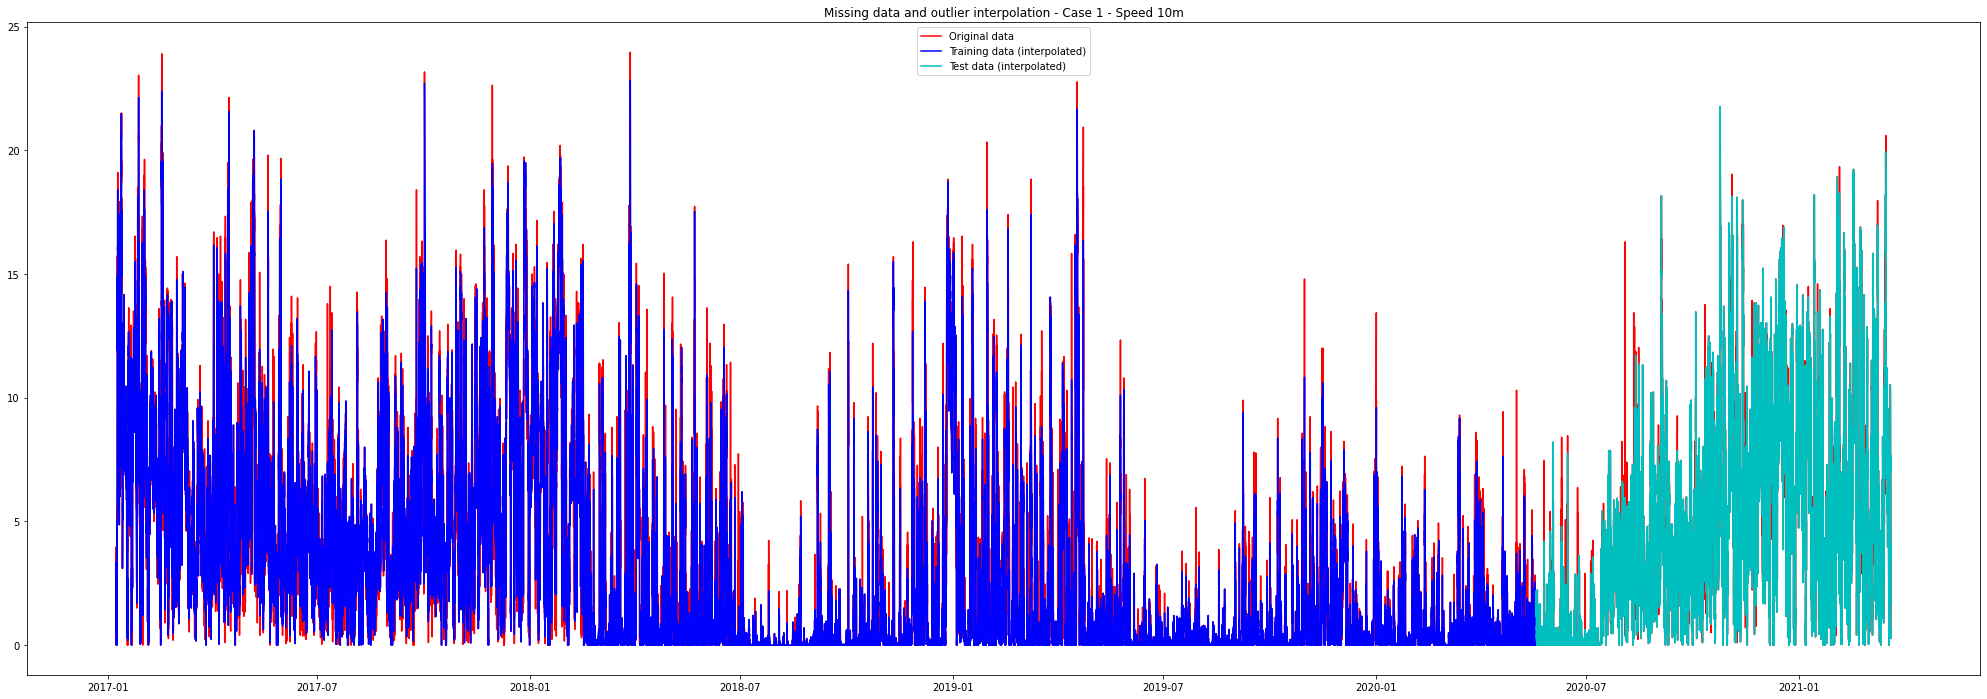

In [13]:
#Visual inspection of missing data and outlier interpolation
fig = plt.figure(figsize=(35,12))

plt.plot(measurement_case_1.index, measurement_case_1['Speed_10m'], 'r', label='Original data')
plt.plot(measurement_train_1.index, measurement_train_1['Speed_10m'], 'b', label='Training data (interpolated)')
plt.plot(measurement_test_1.index, measurement_test_1['Speed_10m'], 'c', label='Test data (interpolated)')
plt.legend(loc='upper center')
plt.title('Missing data and outlier interpolation - Case 1 - Speed 10m')
plt.show()

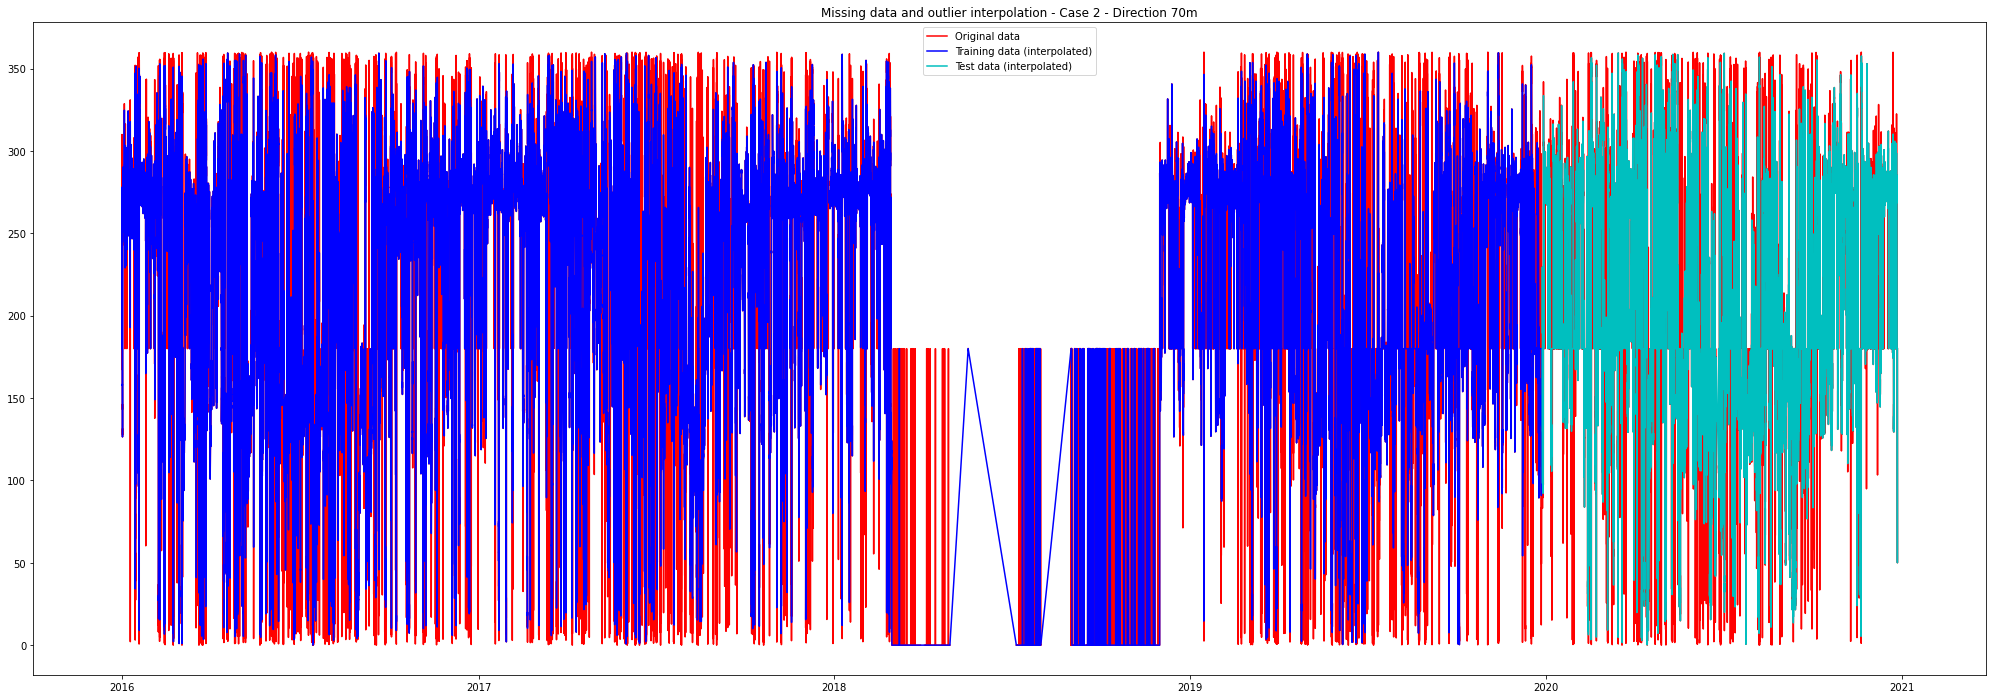

In [14]:
#Visual inspection of missing data and outlier interpolation
fig = plt.figure(figsize=(35,12))

plt.plot(measurement_case_2.index, measurement_case_2['Direction_70m'], 'r', label='Original data')
plt.plot(measurement_train_2.index, measurement_train_2['Direction_70m'], 'b', label='Training data (interpolated)')
plt.plot(measurement_test_2.index, measurement_test_2['Direction_70m'], 'c', label='Test data (interpolated)')
plt.legend(loc='upper center')
plt.title('Missing data and outlier interpolation - Case 2 - Direction 70m')
plt.show()

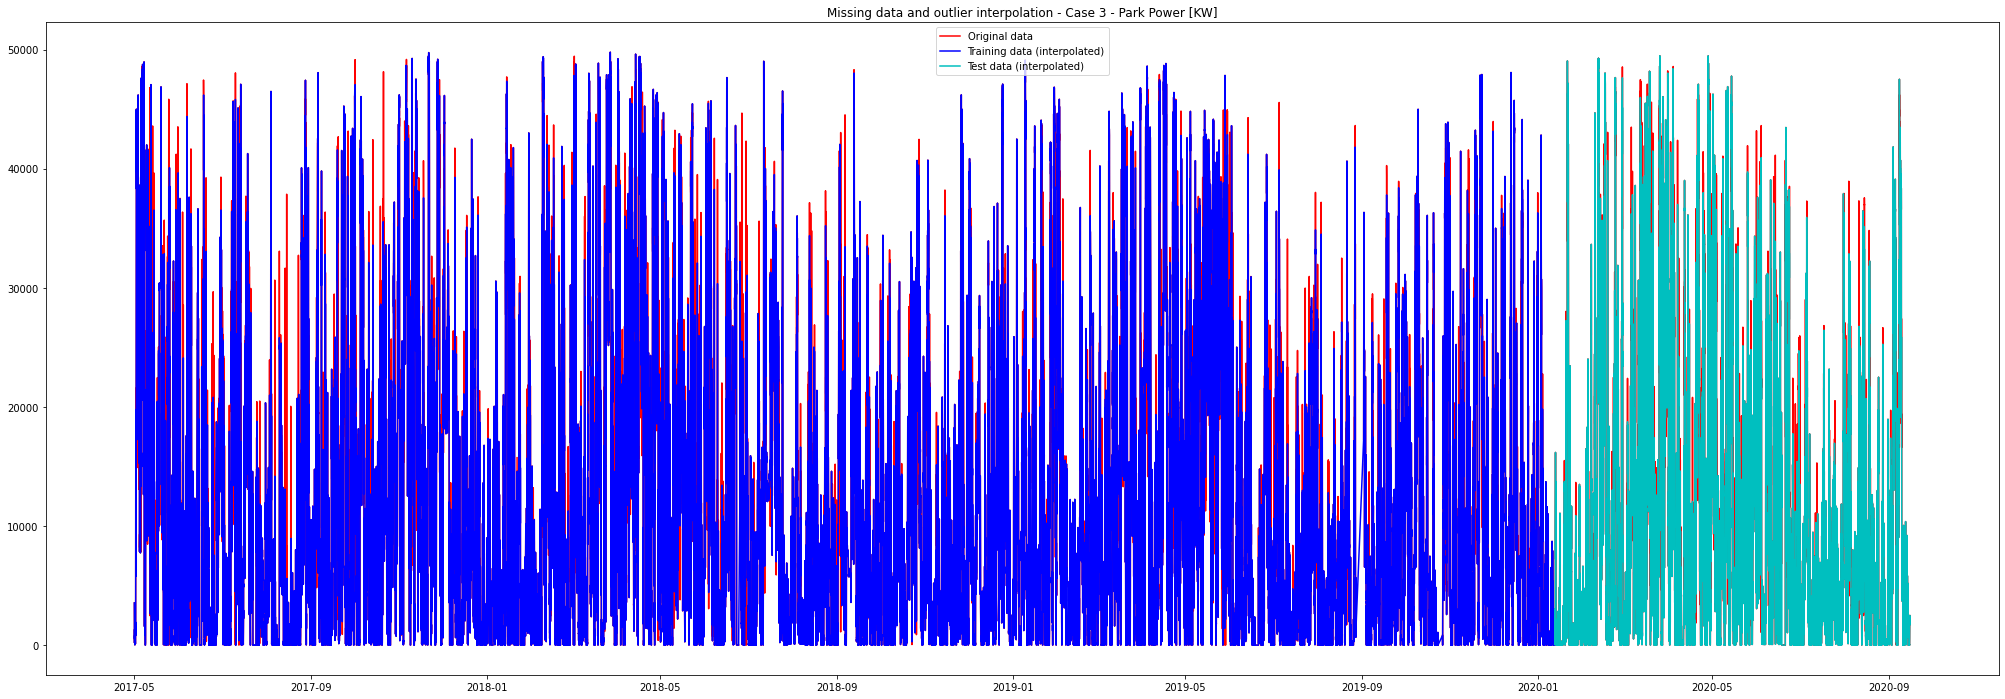

In [15]:
#Visual inspection of missing data and outlier interpolation
fig = plt.figure(figsize=(35,12))

plt.plot(measurement_case_3.index, measurement_case_3['Park Power [KW]'], 'r', label='Original data')
plt.plot(measurement_train_3.index, measurement_train_3['Park Power [KW]'], 'b', label='Training data (interpolated)')
plt.plot(measurement_test_3.index, measurement_test_3['Park Power [KW]'], 'c', label='Test data (interpolated)')
plt.legend(loc='upper center')
plt.title('Missing data and outlier interpolation - Case 3 - Park Power [KW]')
plt.show()

### Data normalization

In [ ]:
# Normalizing the data
# For each column in the training datasets, values are normalized according to max and mins in each column
# The same max and mins are used for the columns in the test datasets, in order to keep proportion

set_columns = ['Speed_10m','Speed_30m','Speed_65m','Speed_70m', \
                'Direction_10m','Direction_30m','Direction_65m','Direction_70m','Park Power [KW]']

# Measurement 1 (train and test)
measurement_norm_1 = {}

for column in set_columns:
    maxvalue = max(measurement_train_1[column].dropna())
    minvalue = min(measurement_train_1[column].dropna())
    measurement_train_1[column] = (measurement_train_1[column]-minvalue)/(maxvalue-minvalue)
    measurement_test_1[column] = (measurement_test_1[column]-minvalue)/(maxvalue-minvalue)
    measurement_norm_1[column] = {"max": maxvalue, "min": minvalue}

# Measurement 2 (train and test)
measurement_norm_2 = {}

for column in set_columns:
    maxvalue = max(measurement_train_2[column].dropna())
    minvalue = min(measurement_train_2[column].dropna())
    measurement_train_2[column] = (measurement_train_2[column]-minvalue)/(maxvalue-minvalue)
    measurement_test_2[column] = (measurement_test_2[column]-minvalue)/(maxvalue-minvalue)
    measurement_norm_2[column] = {"max": maxvalue, "min": minvalue}

set_columns = ['Speed_10m','Speed_30m','Speed_50m','Speed_80m', \
                'Direction_10m','Direction_30m','Direction_50m','Direction_80m','Park Power [KW]']

# Measurement 3 (train and test)
measurement_norm_3 = {}

for column in set_columns:
    maxvalue = max(measurement_train_3[column].dropna())
    minvalue = min(measurement_train_3[column].dropna())
    measurement_train_3[column] = (measurement_train_3[column]-minvalue)/(maxvalue-minvalue)
    measurement_test_3[column] = (measurement_test_3[column]-minvalue)/(maxvalue-minvalue)
    measurement_norm_3[column] = {"max": maxvalue, "min": minvalue}

set_columns = ['Direction_10m','Speed_10m','Temperature_10m','Pressure_seaLevel', \
                'Air Density_10m','Direction_50m','Speed_50m','Temperature_50m','Air Density_50m', \
                'Direction_100m','Speed_100m','Temperature_100m','Air Density_100m','Direction_150m','Speed_150m', \
                'Temperature_150m','Air Density_150m']

# NWP 1 (train and test)
nwp_norm_1 = {}

for column in set_columns:
    maxvalue = max(nwp_train_1[column])
    minvalue = min(nwp_train_1[column])
    nwp_train_1[column] = (nwp_train_1[column]-minvalue)/(maxvalue-minvalue)
    nwp_test_1[column] = (nwp_test_1[column]-minvalue)/(maxvalue-minvalue)
    nwp_norm_1[column] = {"max": maxvalue, "min": minvalue}

# NWP 2 (train and test)
nwp_norm_2 = {}

for column in set_columns:
    maxvalue = max(nwp_train_2[column])
    minvalue = min(nwp_train_2[column])
    nwp_train_2[column] = (nwp_train_2[column]-minvalue)/(maxvalue-minvalue)
    nwp_test_2[column] = (nwp_test_2[column]-minvalue)/(maxvalue-minvalue)
    nwp_norm_2[column] = {"max": maxvalue, "min": minvalue}

# NWP 3 (train and test)
nwp_norm_3 = {}

for column in set_columns:
    maxvalue = max(nwp_train_3[column])
    minvalue = min(nwp_train_3[column])
    nwp_train_3[column] = (nwp_train_3[column]-minvalue)/(maxvalue-minvalue)
    nwp_test_3[column] = (nwp_test_3[column]-minvalue)/(maxvalue-minvalue)
    nwp_norm_3[column] = {"max": maxvalue, "min": minvalue}

## Assembly of datasets for learning

### Normalized training and test sets

In [17]:
# Assembling dataset that will be used for NN training/testing
# Datasets will be kept separate for cases 1, 2, 3

dataset_train_1 = pd.merge(nwp_train_1,measurement_train_1['Park Power [KW]'],left_index=True,right_index=True)
dataset_train_2 = pd.merge(nwp_train_2,measurement_train_2['Park Power [KW]'],left_index=True,right_index=True)
dataset_train_3 = pd.merge(nwp_train_3,measurement_train_3['Park Power [KW]'],left_index=True,right_index=True)
dataset_test_1 = pd.merge(nwp_test_1,measurement_test_1['Park Power [KW]'],left_index=True,right_index=True)
dataset_test_2 = pd.merge(nwp_test_2,measurement_test_2['Park Power [KW]'],left_index=True,right_index=True)
dataset_test_3 = pd.merge(nwp_test_3,measurement_test_3['Park Power [KW]'],left_index=True,right_index=True)

dataset_train_1.reset_index(level=0, inplace=True)
dataset_train_2.reset_index(level=0, inplace=True)
dataset_train_3.reset_index(level=0, inplace=True)
dataset_test_1.reset_index(level=0, inplace=True)
dataset_test_2.reset_index(level=0, inplace=True)
dataset_test_3.reset_index(level=0, inplace=True)

columns_rename = {'Air Density_10m': 'Air_Density_10m', 'Air Density_50m': 'Air_Density_50m', \
                                'Air Density_100m': 'Air_Density_100m', 'Air Density_150m': 'Air_Density_150m', \
                                'Park Power [KW]': 'Park_Power_[KW]' }

dataset_train_1.rename(columns=columns_rename, inplace=True)
dataset_train_2.rename(columns=columns_rename, inplace=True)
dataset_train_3.rename(columns=columns_rename, inplace=True)
dataset_test_1.rename(columns=columns_rename, inplace=True)
dataset_test_2.rename(columns=columns_rename, inplace=True)
dataset_test_3.rename(columns=columns_rename, inplace=True)

### Normalization information

In [18]:
#Storing values used for normalization

normdata = {'Type': ['Max','Min'], \
              'Direction_10m': [nwp_norm_1['Direction_10m']['max'],nwp_norm_1['Direction_10m']['min']], \
              'Speed_10m':  [nwp_norm_1['Speed_10m']['max'],nwp_norm_1['Speed_10m']['min']], \
              'Temperature_10m':  [nwp_norm_1['Temperature_10m']['max'],nwp_norm_1['Temperature_10m']['min']], \
              'Pressure_seaLevel':  [nwp_norm_1['Pressure_seaLevel']['max'],nwp_norm_1['Pressure_seaLevel']['min']], \
              'Air_Density_10m':  [nwp_norm_1['Air Density_10m']['max'],nwp_norm_1['Air Density_10m']['min']], \
              'Direction_50m':  [nwp_norm_1['Direction_50m']['max'],nwp_norm_1['Direction_50m']['min']], \
              'Speed_50m':  [nwp_norm_1['Speed_50m']['max'],nwp_norm_1['Speed_50m']['min']], \
              'Temperature_50m':  [nwp_norm_1['Temperature_50m']['max'],nwp_norm_1['Temperature_50m']['min']], \
              'Air_Density_50m':  [nwp_norm_1['Air Density_50m']['max'],nwp_norm_1['Air Density_50m']['min']], \
              'Direction_100m':  [nwp_norm_1['Direction_100m']['max'],nwp_norm_1['Direction_100m']['min']], \
              'Speed_100m':  [nwp_norm_1['Speed_100m']['max'],nwp_norm_1['Speed_100m']['min']], \
              'Temperature_100m':  [nwp_norm_1['Temperature_100m']['max'],nwp_norm_1['Temperature_100m']['min']], \
              'Air_Density_100m': [nwp_norm_1['Air Density_100m']['max'],nwp_norm_1['Air Density_100m']['min']], \
              'Direction_150m':  [nwp_norm_1['Direction_150m']['max'],nwp_norm_1['Direction_150m']['min']], \
              'Speed_150m':  [nwp_norm_1['Speed_150m']['max'],nwp_norm_1['Speed_150m']['min']], \
              'Temperature_150m':  [nwp_norm_1['Temperature_150m']['max'],nwp_norm_1['Temperature_150m']['min']], \
              'Air_Density_150m':  [nwp_norm_1['Air Density_150m']['max'],nwp_norm_1['Air Density_150m']['min']], \
              'Park_Power_[KW]':  [measurement_norm_1['Park Power [KW]']['max'],measurement_norm_1['Park Power [KW]']['min']] }

dataset_normdata_1 = pd.DataFrame(normdata)

normdata = {'Type': ['Max','Min'], \
              'Direction_10m': [nwp_norm_2['Direction_10m']['max'],nwp_norm_2['Direction_10m']['min']], \
              'Speed_10m':  [nwp_norm_2['Speed_10m']['max'],nwp_norm_2['Speed_10m']['min']], \
              'Temperature_10m':  [nwp_norm_2['Temperature_10m']['max'],nwp_norm_2['Temperature_10m']['min']], \
              'Pressure_seaLevel':  [nwp_norm_2['Pressure_seaLevel']['max'],nwp_norm_2['Pressure_seaLevel']['min']], \
              'Air_Density_10m':  [nwp_norm_2['Air Density_10m']['max'],nwp_norm_2['Air Density_10m']['min']], \
              'Direction_50m':  [nwp_norm_2['Direction_50m']['max'],nwp_norm_2['Direction_50m']['min']], \
              'Speed_50m':  [nwp_norm_2['Speed_50m']['max'],nwp_norm_2['Speed_50m']['min']], \
              'Temperature_50m':  [nwp_norm_2['Temperature_50m']['max'],nwp_norm_2['Temperature_50m']['min']], \
              'Air_Density_50m':  [nwp_norm_2['Air Density_50m']['max'],nwp_norm_2['Air Density_50m']['min']], \
              'Direction_100m':  [nwp_norm_2['Direction_100m']['max'],nwp_norm_2['Direction_100m']['min']], \
              'Speed_100m':  [nwp_norm_2['Speed_100m']['max'],nwp_norm_2['Speed_100m']['min']], \
              'Temperature_100m':  [nwp_norm_2['Temperature_100m']['max'],nwp_norm_2['Temperature_100m']['min']], \
              'Air_Density_100m': [nwp_norm_2['Air Density_100m']['max'],nwp_norm_2['Air Density_100m']['min']], \
              'Direction_150m':  [nwp_norm_2['Direction_150m']['max'],nwp_norm_2['Direction_150m']['min']], \
              'Speed_150m':  [nwp_norm_2['Speed_150m']['max'],nwp_norm_2['Speed_150m']['min']], \
              'Temperature_150m':  [nwp_norm_2['Temperature_150m']['max'],nwp_norm_2['Temperature_150m']['min']], \
              'Air_Density_150m':  [nwp_norm_2['Air Density_150m']['max'],nwp_norm_2['Air Density_150m']['min']], \
              'Park_Power_[KW]':  [measurement_norm_2['Park Power [KW]']['max'],measurement_norm_2['Park Power [KW]']['min']] }

dataset_normdata_2 = pd.DataFrame(normdata)

normdata = {'Type': ['Max','Min'], \
              'Direction_10m': [nwp_norm_3['Direction_10m']['max'],nwp_norm_3['Direction_10m']['min']], \
              'Speed_10m':  [nwp_norm_3['Speed_10m']['max'],nwp_norm_3['Speed_10m']['min']], \
              'Temperature_10m':  [nwp_norm_3['Temperature_10m']['max'],nwp_norm_3['Temperature_10m']['min']], \
              'Pressure_seaLevel':  [nwp_norm_3['Pressure_seaLevel']['max'],nwp_norm_3['Pressure_seaLevel']['min']], \
              'Air_Density_10m':  [nwp_norm_3['Air Density_10m']['max'],nwp_norm_3['Air Density_10m']['min']], \
              'Direction_50m':  [nwp_norm_3['Direction_50m']['max'],nwp_norm_3['Direction_50m']['min']], \
              'Speed_50m':  [nwp_norm_3['Speed_50m']['max'],nwp_norm_3['Speed_50m']['min']], \
              'Temperature_50m':  [nwp_norm_3['Temperature_50m']['max'],nwp_norm_3['Temperature_50m']['min']], \
              'Air_Density_50m':  [nwp_norm_3['Air Density_50m']['max'],nwp_norm_3['Air Density_50m']['min']], \
              'Direction_100m':  [nwp_norm_3['Direction_100m']['max'],nwp_norm_3['Direction_100m']['min']], \
              'Speed_100m':  [nwp_norm_3['Speed_100m']['max'],nwp_norm_3['Speed_100m']['min']], \
              'Temperature_100m':  [nwp_norm_3['Temperature_100m']['max'],nwp_norm_3['Temperature_100m']['min']], \
              'Air_Density_100m': [nwp_norm_3['Air Density_100m']['max'],nwp_norm_3['Air Density_100m']['min']], \
              'Direction_150m':  [nwp_norm_3['Direction_150m']['max'],nwp_norm_3['Direction_150m']['min']], \
              'Speed_150m':  [nwp_norm_3['Speed_150m']['max'],nwp_norm_3['Speed_150m']['min']], \
              'Temperature_150m':  [nwp_norm_3['Temperature_150m']['max'],nwp_norm_3['Temperature_150m']['min']], \
              'Air_Density_150m':  [nwp_norm_3['Air Density_150m']['max'],nwp_norm_3['Air Density_150m']['min']], \
              'Park_Power_[KW]':  [measurement_norm_3['Park Power [KW]']['max'],measurement_norm_3['Park Power [KW]']['min']] }

dataset_normdata_3 = pd.DataFrame(normdata)
dataset_normdata_3

,Type,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,Max,359.0,11.0,35.8,1021.4,1.432,359.0,9.7,35.8,1.432,359.0,16.0,35.8,1.432,359.0,23.0,35.8,1.432,49789.0
1,Min,0.0,0.0,-25.8,962.0,1.109,0.0,0.1,-25.8,1.109,0.0,0.0,-25.8,1.109,0.0,0.1,-25.8,1.109,0.0


In [19]:
#Inspecting example dataset
dataset_train_1.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


## Data inspection for feature selection

### Case 1: height-related features

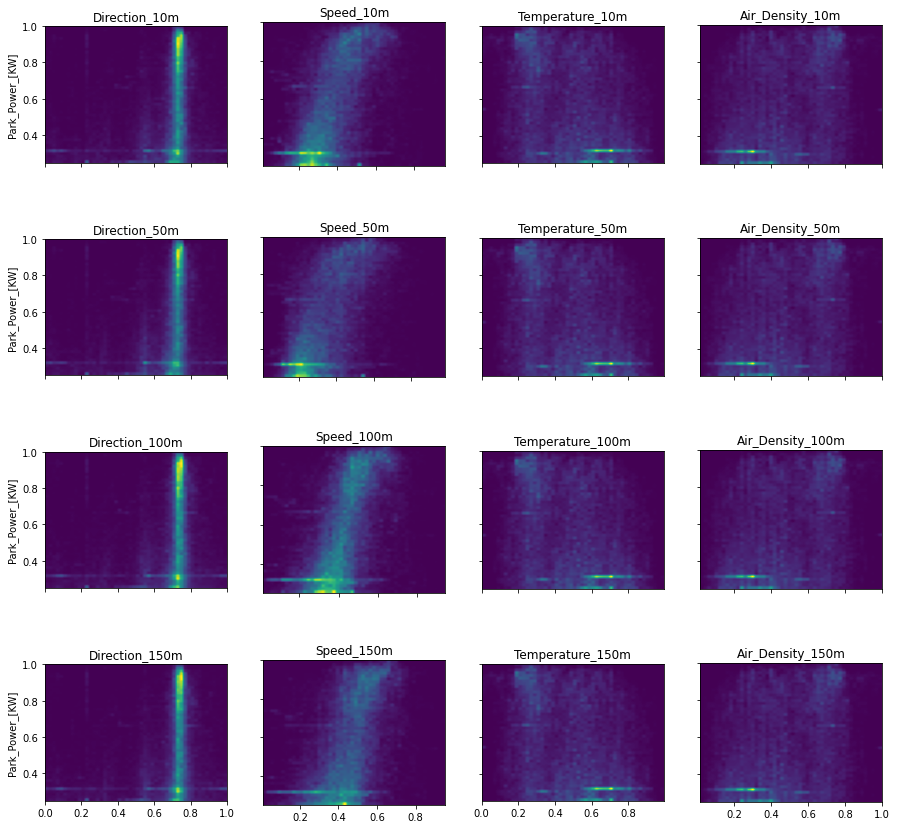

In [20]:
#Plotting features for case 1 (training data)
fig, axs = plt.subplots(4, 4, figsize=(15,15))

plot_df = dataset_train_1[dataset_train_1['Park_Power_[KW]'] >= 0.25]
plot_y = 'Park_Power_[KW]'

plot_x = 'Direction_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 0].set_title(plot_x)

plot_x = 'Speed_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 1].set_title(plot_x)

plot_x = 'Temperature_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 2].set_title(plot_x)

plot_x = 'Air_Density_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 3].set_title(plot_x)

plot_x = 'Direction_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 0].set_title(plot_x)

plot_x = 'Speed_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 1].set_title(plot_x)

plot_x = 'Temperature_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 2].set_title(plot_x)

plot_x = 'Air_Density_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 3].set_title(plot_x)

plot_x = 'Direction_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 0].set_title(plot_x)

plot_x = 'Speed_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 1].set_title(plot_x)

plot_x = 'Temperature_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 2].set_title(plot_x)

plot_x = 'Air_Density_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 3].set_title(plot_x)

plot_x = 'Direction_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 0].set_title(plot_x)

plot_x = 'Speed_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 1].set_title(plot_x)

plot_x = 'Temperature_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 2].set_title(plot_x)

plot_x = 'Air_Density_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 3].set_title(plot_x)

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Park_Power_[KW]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Case 2: height-related features

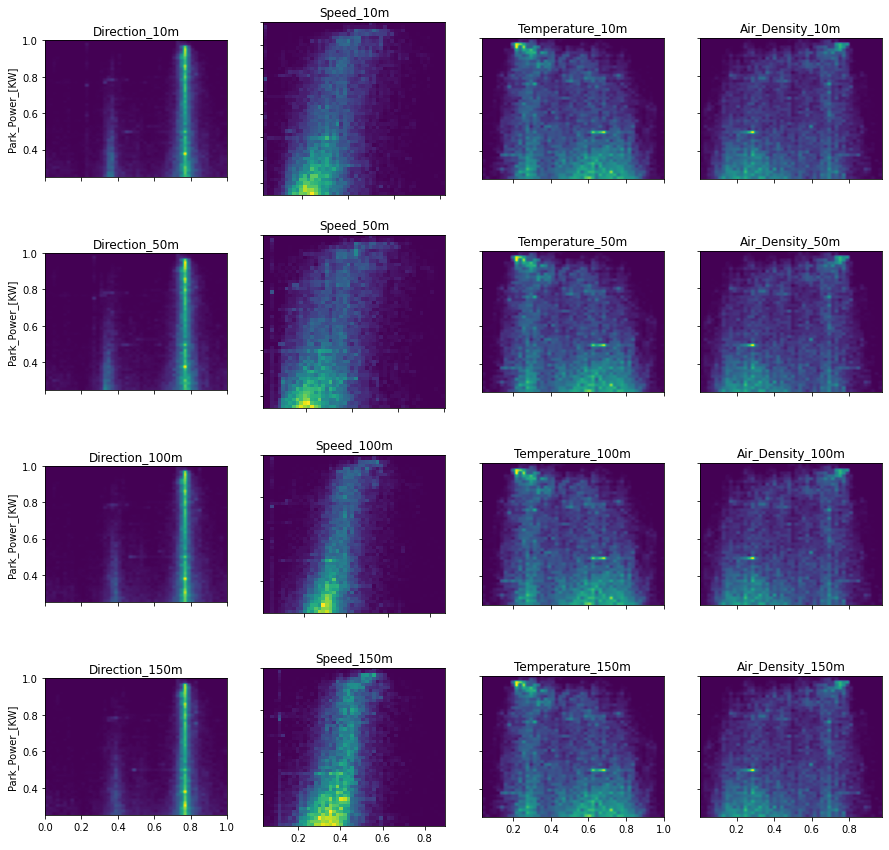

In [21]:
#Plotting features for case 2 (training data)
fig, axs = plt.subplots(4, 4, figsize=(15,15))

plot_df = dataset_train_2[dataset_train_2['Park_Power_[KW]'] >= 0.25]
plot_y = 'Park_Power_[KW]'

plot_x = 'Direction_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 0].set_title(plot_x)

plot_x = 'Speed_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 1].set_title(plot_x)

plot_x = 'Temperature_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 2].set_title(plot_x)

plot_x = 'Air_Density_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 3].set_title(plot_x)

plot_x = 'Direction_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 0].set_title(plot_x)

plot_x = 'Speed_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 1].set_title(plot_x)

plot_x = 'Temperature_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 2].set_title(plot_x)

plot_x = 'Air_Density_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 3].set_title(plot_x)

plot_x = 'Direction_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 0].set_title(plot_x)

plot_x = 'Speed_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 1].set_title(plot_x)

plot_x = 'Temperature_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 2].set_title(plot_x)

plot_x = 'Air_Density_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 3].set_title(plot_x)

plot_x = 'Direction_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 0].set_title(plot_x)

plot_x = 'Speed_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 1].set_title(plot_x)

plot_x = 'Temperature_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 2].set_title(plot_x)

plot_x = 'Air_Density_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 3].set_title(plot_x)

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Park_Power_[KW]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Case 3: height-related features


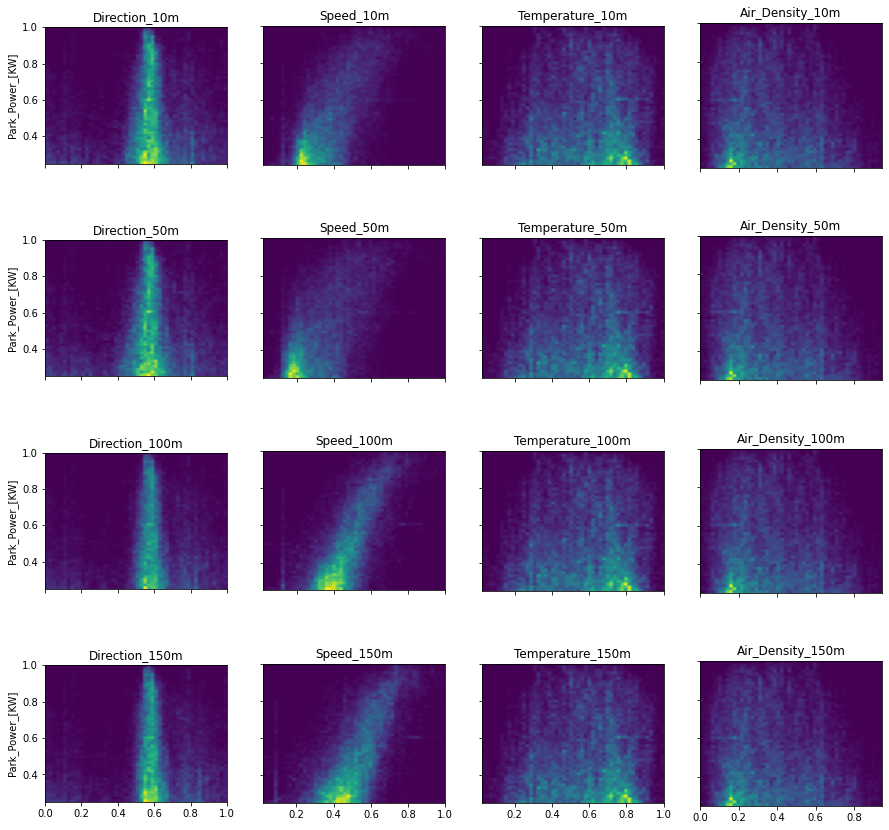

In [22]:
#Plotting features for case 3 (training data)
fig, axs = plt.subplots(4, 4, figsize=(15,15))

plot_df = dataset_train_3[dataset_train_3['Park_Power_[KW]'] >= 0.25]
plot_y = 'Park_Power_[KW]'

plot_x = 'Direction_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 0].set_title(plot_x)

plot_x = 'Speed_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 1].set_title(plot_x)

plot_x = 'Temperature_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 2].set_title(plot_x)

plot_x = 'Air_Density_10m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[0, 3].set_title(plot_x)

plot_x = 'Direction_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 0].set_title(plot_x)

plot_x = 'Speed_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 1].set_title(plot_x)

plot_x = 'Temperature_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 2].set_title(plot_x)

plot_x = 'Air_Density_50m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[1, 3].set_title(plot_x)

plot_x = 'Direction_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 0].set_title(plot_x)

plot_x = 'Speed_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 1].set_title(plot_x)

plot_x = 'Temperature_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 2].set_title(plot_x)

plot_x = 'Air_Density_100m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[2, 3].set_title(plot_x)

plot_x = 'Direction_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 0].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 0].set_title(plot_x)

plot_x = 'Speed_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 1].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 1].set_title(plot_x)

plot_x = 'Temperature_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 2].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 2].set_title(plot_x)

plot_x = 'Air_Density_150m'
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[3, 3].imshow(heatmap.T, extent=extent, origin='lower')
axs[3, 3].set_title(plot_x)

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Park_Power_[KW]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Other features

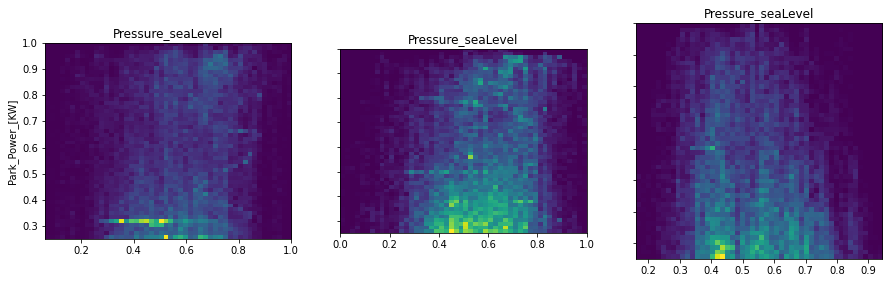

In [23]:
#Plotting features for pressure sea level (training data, all cases)
fig, axs = plt.subplots(1, 3, figsize=(15,15))

plot_x = 'Pressure_seaLevel'
plot_y = 'Park_Power_[KW]'

plot_df = dataset_train_1[dataset_train_1['Park_Power_[KW]'] >= 0.25]
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[0].imshow(heatmap.T, extent=extent, origin='lower')
axs[0].set_title(plot_x)

plot_df = dataset_train_2[dataset_train_2['Park_Power_[KW]'] >= 0.25]
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[1].imshow(heatmap.T, extent=extent, origin='lower')
axs[1].set_title(plot_x)

plot_df = dataset_train_3[dataset_train_3['Park_Power_[KW]'] >= 0.25]
heatmap, xedges, yedges = np.histogram2d(plot_df[plot_x], plot_df[plot_y], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
axs[2].imshow(heatmap.T, extent=extent, origin='lower')
axs[2].set_title(plot_x)

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Park_Power_[KW]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Baseline Model

## Definition and Training

Text(0.5, 0.98, 'Turbine Power Output for Wind Farms #1 #2 #3')

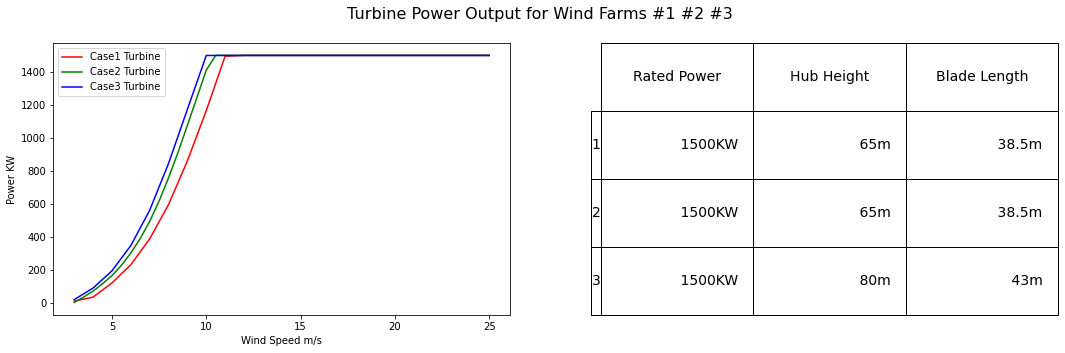

In [24]:
fig = plt.figure(figsize=(18,5))

ax1 = fig.add_subplot(121)
all_turbines_power_curve_dataframe.plot(kind='line',y='Case1 Turbine',style=['r-'], ax=ax1)
all_turbines_power_curve_dataframe.plot(kind='line',y='Case2 Turbine',style=['g-'], ax=ax1)
all_turbines_power_curve_dataframe.plot(kind='line',y='Case3 Turbine',style=['b-'], ax=ax1)
ax1.set_ylabel('Power KW')
ax1.set_xlabel('Wind Speed m/s')

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = all_turbines_info_dataframe.values, rowLabels = all_turbines_info_dataframe.index, bbox=bbox, colLabels=all_turbines_info_dataframe.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

fig.suptitle('Turbine Power Output for Wind Farms #1 #2 #3', fontsize=16)

### Case 1

In [25]:
# Creating baseline model for Case 1

baseline_1 = all_turbines_power_curve_dataframe.reset_index(level=0)[['Wind Speed','Case1 Turbine']]

park_size = 33
max_wind_speed = 0.7*dataset_normdata_1[dataset_normdata_1['Type'] == 'Max']['Speed_50m'].squeeze() + 0.3*dataset_normdata_1[dataset_normdata_1['Type'] == 'Max']['Speed_100m'].squeeze()
min_wind_speed = 0.7*dataset_normdata_1[dataset_normdata_1['Type'] == 'Min']['Speed_50m'].squeeze() + 0.3*dataset_normdata_1[dataset_normdata_1['Type'] == 'Min']['Speed_100m'].squeeze()
max_park_power = dataset_normdata_1[dataset_normdata_1['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
min_park_power = dataset_normdata_1[dataset_normdata_1['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

baseline_1_norm = pd.DataFrame()
baseline_1_norm['Wind_Speed'] = round((baseline_1['Wind Speed']-min_wind_speed)/(max_wind_speed-min_wind_speed),2)
baseline_1_norm['Park_Power_[KW]'] = (park_size*baseline_1['Case1 Turbine']-min_park_power)/(max_park_power-min_park_power)

baseline_1_train = pd.DataFrame()
baseline_1_train['Wind_Speed'] = np.arange(0.0, max(1.01,max(baseline_1_norm['Wind_Speed'])+0.01), 0.01)

baseline_1_train = pd.merge(baseline_1_train,baseline_1_norm,how='left',on='Wind_Speed')
baseline_1_train.interpolate(inplace=True, limit_direction='both')
baseline_1_train

,Wind_Speed,Park_Power_[KW]
0,0.00,0.012666
1,0.01,0.012666
2,0.02,0.012666
3,0.03,0.012666
4,0.04,0.012666
...,...,...
177,1.77,0.992231
178,1.78,0.992231
179,1.79,0.992231
180,1.80,0.992231


### Case 2

In [27]:
# Creating baseline model for Case 2

baseline_2 = all_turbines_power_curve_dataframe.reset_index(level=0)[['Wind Speed','Case2 Turbine']]

park_size = 66
max_wind_speed = 0.7*dataset_normdata_2[dataset_normdata_2['Type'] == 'Max']['Speed_50m'].squeeze() + 0.3*dataset_normdata_2[dataset_normdata_2['Type'] == 'Max']['Speed_100m'].squeeze()
min_wind_speed = 0.7*dataset_normdata_2[dataset_normdata_2['Type'] == 'Min']['Speed_50m'].squeeze() + 0.3*dataset_normdata_2[dataset_normdata_2['Type'] == 'Min']['Speed_100m'].squeeze()
max_park_power = dataset_normdata_2[dataset_normdata_2['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
min_park_power = dataset_normdata_2[dataset_normdata_2['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

baseline_2_norm = pd.DataFrame()
baseline_2_norm['Wind_Speed'] = round((baseline_2['Wind Speed']-min_wind_speed)/(max_wind_speed-min_wind_speed),2)
baseline_2_norm['Park_Power_[KW]'] = (park_size*baseline_2['Case2 Turbine']-min_park_power)/(max_park_power-min_park_power)

baseline_2_train = pd.DataFrame()
baseline_2_train['Wind_Speed'] = np.arange(0.0, max(1.01,max(baseline_2_norm['Wind_Speed'])+0.01), 0.01)

baseline_2_train = pd.merge(baseline_2_train,baseline_2_norm,how='left',on='Wind_Speed')
baseline_2_train.interpolate(inplace=True, limit_direction='both')
baseline_2_train

,Wind_Speed,Park_Power_[KW]
0,0.00,0.003418
1,0.01,0.003418
2,0.02,0.003418
3,0.03,0.003418
4,0.04,0.003418
...,...,...
155,1.55,0.984522
156,1.56,0.984522
157,1.57,0.984522
158,1.58,0.984522


### Case 3

In [28]:
# Creating baseline values for Case 3

baseline_3 = all_turbines_power_curve_dataframe.reset_index(level=0)[['Wind Speed','Case3 Turbine']]

park_size = 33
max_wind_speed = 0.4*dataset_normdata_3[dataset_normdata_3['Type'] == 'Max']['Speed_50m'].squeeze() + 0.6*dataset_normdata_3[dataset_normdata_3['Type'] == 'Max']['Speed_100m'].squeeze()
min_wind_speed = 0.4*dataset_normdata_3[dataset_normdata_3['Type'] == 'Min']['Speed_50m'].squeeze() + 0.6*dataset_normdata_3[dataset_normdata_3['Type'] == 'Min']['Speed_100m'].squeeze()
max_park_power = dataset_normdata_3[dataset_normdata_3['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
min_park_power = dataset_normdata_3[dataset_normdata_3['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

baseline_3_norm = pd.DataFrame()
baseline_3_norm['Wind_Speed'] = round((baseline_3['Wind Speed']-min_wind_speed)/(max_wind_speed-min_wind_speed),2)
baseline_3_norm['Park_Power_[KW]'] = (park_size*baseline_3['Case3 Turbine']-min_park_power)/(max_park_power-min_park_power)

baseline_3_train = pd.DataFrame()
baseline_3_train['Wind_Speed'] = np.arange(0.0, max(1.01,max(baseline_3_norm['Wind_Speed'])+0.01), 0.01)

baseline_3_train = pd.merge(baseline_3_train,baseline_3_norm,how='left',on='Wind_Speed')
baseline_3_train.interpolate(inplace=True, limit_direction='both')
baseline_3_train

,Wind_Speed,Park_Power_[KW]
0,0.00,0.014383
1,0.01,0.014383
2,0.02,0.014383
3,0.03,0.014383
4,0.04,0.014383
...,...,...
182,1.82,0.994196
183,1.83,0.994196
184,1.84,0.994196
185,1.85,0.994196


## Prediction and Error Measurements

In [29]:
# Error measurement functions
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)))) * 100

def accuracy_rate(y_true, y_pred, cap):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (1 - (np.sqrt(np.mean((y_true - y_pred) ** 2))/cap)) * 100

### Case 1

In [30]:
# Predictions for Case 1
test_set_x = round(0.7*dataset_test_1['Speed_50m'] + 0.3*dataset_test_1['Speed_100m'],2)
test_set_x[test_set_x < 0] = 0
test_set_y = dataset_test_1['Park_Power_[KW]']
test_predict = []

for i in range(0,len(test_set_y)):
  test_predict.append(baseline_1_train['Park_Power_[KW]'][int(test_set_x[i]*100)])

test_predict = pd.Series(test_predict)
test_values = test_set_y

dataset_conversions = dataset_normdata_1
norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [31]:
# Error measurements for Case 1
cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)

rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  17599.358281950266
mae:  12232.897161601646
rms (normalized):  0.3555425915545508
mae (normalized):  0.24712923558791206
smape:  70.05908457587455
accuracy:  64.44574084454491


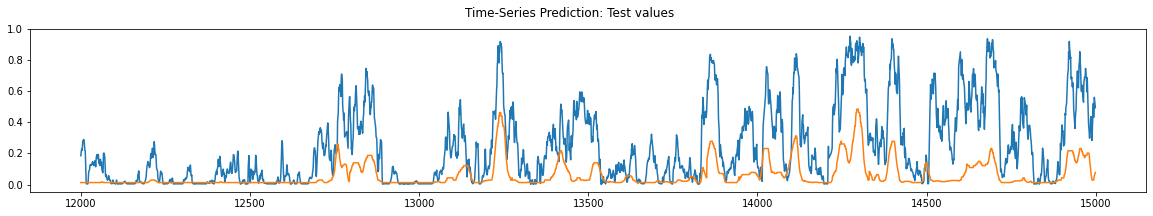

In [32]:
# Plotting predicted test values for Case 1

# Set here the start and end index of data in order to zoom in
start_index = 12000
end_index = 15000

dataY_plot = test_set_y[start_index:end_index]
data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Test values')
plt.show()

### Case 2

In [33]:
# Predictions for Case 2
test_set_x = round(0.7*dataset_test_2['Speed_50m'] + 0.3*dataset_test_2['Speed_100m'],2)
test_set_x[test_set_x < 0] = 0
test_set_y = dataset_test_2['Park_Power_[KW]']
test_predict = []

for i in range(0,len(test_set_y)):
  test_predict.append(baseline_2_train['Park_Power_[KW]'][int(test_set_x[i]*100)])

test_predict = pd.Series(test_predict)
test_values = test_set_y

dataset_conversions = dataset_normdata_2
norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [34]:
# Error measurements for Case 2
cap = 99000

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)

rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  28531.116077626197
mae:  18502.020791378727
rms (normalized):  0.2881930916931939
mae (normalized):  0.18688909890281544
smape:  72.03000957461609
accuracy:  71.18069083068062


### Case 3

In [35]:
# Predictions for Case 3
test_set_x = round(0.4*dataset_test_3['Speed_50m'] + 0.6*dataset_test_3['Speed_100m'],2)
test_set_x[test_set_x < 0] = 0
test_set_y = dataset_test_3['Park_Power_[KW]']
test_predict = []

for i in range(0,len(test_set_y)):
  test_predict.append(baseline_3_train['Park_Power_[KW]'][int(test_set_x[i]*100)])

test_predict = pd.Series(test_predict)
test_values = test_set_y

dataset_conversions = dataset_normdata_3
norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [36]:
# Error measurements for Case 3
cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)

rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  9002.495161168481
mae:  5797.532353806287
rms (normalized):  0.18186858911451476
mae (normalized):  0.11712186573346034
smape:  49.2346346015648
accuracy:  81.81314108854852


# RNN Model

## Definition

In [ ]:
# Checking if CUDA (GPU) is available

cuda_available = torch.cuda.is_available()
print("Running GPU.") if cuda_available else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if cuda_available:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if cuda_available:
        return x.cpu().data.numpy()
    return x.data.numpy()

# Empty CUDA cache, just in case
import gc
gc.collect()
torch.cuda.empty_cache()

Running GPU.


In [ ]:
# Definition of the network

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        if cuda_available:
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size).cuda())
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size).cuda())
        else:
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size))
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        out = self.sigmoid(out)

        return out

In [ ]:
# This function is a manual implementation, similar to other implementations like TimeSeriesData

def sliding_windows(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(data_x)-seq_length_future+1):
        _x = data_x[(i-seq_length_past):(i+seq_length_future)]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

## Case 1

### Training

In [ ]:
training_set_x = dataset_train_1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
training_set_y = dataset_train_1[['Park_Power_[KW]']]

test_set_x = dataset_test_1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
test_set_y = dataset_test_1[['Park_Power_[KW]']]

#Transforming to normal arrays
training_set_x = training_set_x.values
test_set_x = test_set_x.values

training_set_y = training_set_y.values
test_set_y = test_set_y.values

In [ ]:
# Length of sequences to be fed into NN is defined here

# seq_length_past = 99 means the last 99 timesteps are included in the sequence
# seq_length_future = 1 means the current timestep is included in the sequence (>1 also includes future timesteps)
seq_length_past = 99
seq_length_future = 1

# Assembling sequences for training set
x, y = sliding_windows(training_set_x, training_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

# Assembling sequences for test set
x, y = sliding_windows(test_set_x, test_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

In [ ]:
# Defining training settings

num_epochs = 150
learning_rate = 1e-3
batch_size = 1000

input_size = trainX.shape[2]    #number of features
hidden_size = 20                #number of hidden units
num_layers = 1                  #number of LSTM layers

num_classes = 1

if cuda_available:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
else:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Moving sequences into data loader

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(dataset=TensorDataset(trainX,trainY),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=TensorDataset(testX,testY),batch_size=batch_size,shuffle=False)

In [ ]:
# Training the model
train_losses_plot = []
test_losses_plot = []

for epoch in range(num_epochs+1):
    train_losses = []
    test_losses = []

    lstm.train()
    for x_batch, y_batch in train_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    ### Validate on test set
    lstm.eval()
    for x_batch, y_batch in test_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        test_losses.append(loss.item())

    train_losses_plot.append(np.mean(train_losses))
    test_losses_plot.append(np.mean(test_losses))

    if epoch % 50 == 0:   # Reporting results from time to time to track learning progress
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, np.mean(train_losses), np.mean(test_losses)))

Epoch: 0, training loss: 0.08259, validation loss: 0.06089
Epoch: 50, training loss: 0.03683, validation loss: 0.03259
Epoch: 100, training loss: 0.03405, validation loss: 0.03553
Epoch: 150, training loss: 0.03256, validation loss: 0.03414


(0.0, 150.0)

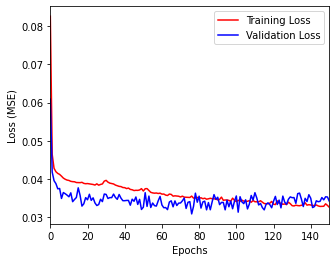

In [ ]:
epoch = np.arange(len(train_losses_plot))
plt.figure(figsize=(5, 4))
plt.plot(epoch, train_losses_plot, 'r', epoch, test_losses_plot, 'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim(0,150)

### Prediction and Validation

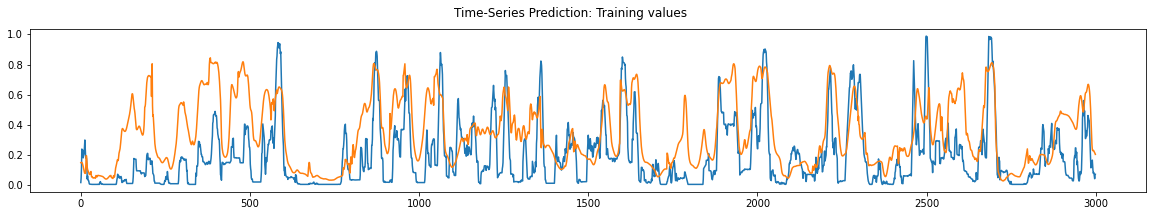

Loss:  0.03267458159343793


In [ ]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  train_predict = train_predict.cpu()

# Calculating loss of fitted training data
loss = criterion(train_predict[:,0], torch.tensor(training_set_y[:,0][seq_length_past:]))

train_predict = train_predict.data.numpy()
train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,train_predict))

# Set here the start and end index of data in order to zoom in
start_index = 2000
end_index = 5000

dataY_plot = training_set_y[start_index:end_index]
data_predict = train_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Training values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

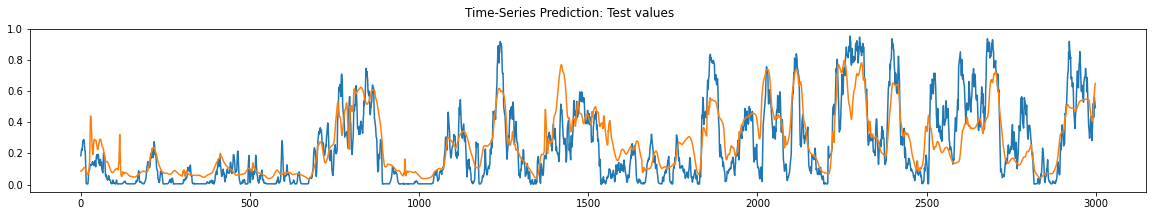

Loss:  0.03296692505117126


In [ ]:
# Plotting predicted test values

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

# Calculating loss of predicted test data
loss = criterion(test_predict[:,0], torch.tensor(test_set_y[:,0][seq_length_past:]))

test_predict = test_predict.data.numpy()
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = 12000
end_index = 15000

dataY_plot = test_set_y[start_index:end_index]
data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Test values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

### Error Measurements

In [ ]:
full_set_x = np.concatenate((training_set_x,test_set_x))
full_set_y = np.concatenate((training_set_y,test_set_y))

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, full_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

In [ ]:
# Predicting test values

lstm.eval()
full_predict = lstm(trainX)
test_predict = full_predict[len(full_predict)-len(test_set_y):]
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
test_values = test_set_y

dataset_conversions = dataset_normdata_1
norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [ ]:
#Error measurements

cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)
rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  9101.94152018408
mae:  6716.932099360567
rms (normalized):  0.18387760646836526
mae (normalized):  0.13569559796688013
smape:  39.88537218552873
accuracy:  81.61223935316347


## Case 2

### Training

In [ ]:
training_set_x = dataset_train_2[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
training_set_y = dataset_train_2[['Park_Power_[KW]']]

test_set_x = dataset_test_2[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
test_set_y = dataset_test_2[['Park_Power_[KW]']]

#Transforming to normal arrays
training_set_x = training_set_x.values
test_set_x = test_set_x.values

training_set_y = training_set_y.values
test_set_y = test_set_y.values

In [ ]:
# Length of sequences to be fed into NN is defined here

# seq_length_past = 99 means the last 99 timesteps are included in the sequence
# seq_length_future = 1 means the current timestep is included in the sequence (>1 also includes future timesteps)
seq_length_past = 99
seq_length_future = 1

# Assembling sequences for training set
x, y = sliding_windows(training_set_x, training_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

# Assembling sequences for test set
x, y = sliding_windows(test_set_x, test_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

In [ ]:
# Defining training settings

num_epochs = 150
learning_rate = 1e-3
batch_size = 1000

input_size = trainX.shape[2]    #number of features
hidden_size = 20                #number of hidden units
num_layers = 1                  #number of LSTM layers

num_classes = 1

if cuda_available:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
else:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Moving sequences into data loader

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(dataset=TensorDataset(trainX,trainY),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=TensorDataset(testX,testY),batch_size=batch_size,shuffle=False)

In [ ]:
# Training the model
train_losses_plot = []
test_losses_plot = []

for epoch in range(num_epochs+1):
    train_losses = []
    test_losses = []

    lstm.train()
    for x_batch, y_batch in train_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    ### Validate on test set
    lstm.eval()
    for x_batch, y_batch in test_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        test_losses.append(loss.item())

    train_losses_plot.append(np.mean(train_losses))
    test_losses_plot.append(np.mean(test_losses))

    if epoch % 50 == 0:   # Reporting results from time to time to track learning progress
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, np.mean(train_losses), np.mean(test_losses)))

Epoch: 0, training loss: 0.08188, validation loss: 0.07139
Epoch: 50, training loss: 0.02997, validation loss: 0.03565
Epoch: 100, training loss: 0.02714, validation loss: 0.03494
Epoch: 150, training loss: 0.02578, validation loss: 0.03925


(0.0, 150.0)

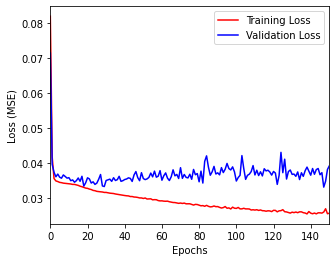

In [ ]:
epoch = np.arange(len(train_losses_plot))
plt.figure(figsize=(5, 4))
plt.plot(epoch, train_losses_plot, 'r', epoch, test_losses_plot, 'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim(0,150)

### Prediction and Validation

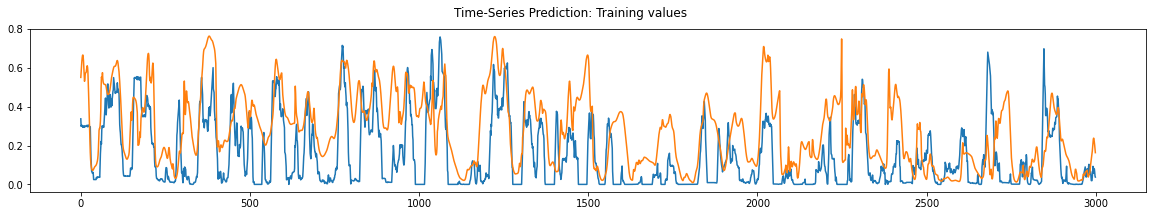

Loss:  0.029665062885289722


In [ ]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  train_predict = train_predict.cpu()

# Calculating loss of fitted training data
loss = criterion(train_predict[:,0], torch.tensor(training_set_y[:,0][seq_length_past:]))

train_predict = train_predict.data.numpy()
train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,train_predict))

# Set here the start and end index of data in order to zoom in
start_index = 2000
end_index = 5000

dataY_plot = training_set_y[start_index:end_index]
data_predict = train_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Training values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

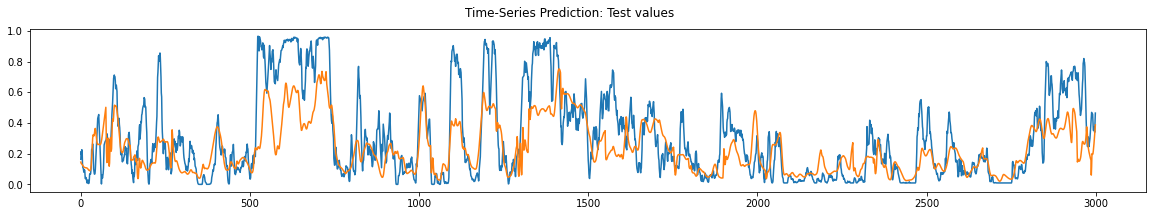

Loss:  0.03916810532515099


In [ ]:
# Plotting predicted test values

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

# Calculating loss of predicted test data
loss = criterion(test_predict[:,0], torch.tensor(test_set_y[:,0][seq_length_past:]))

test_predict = test_predict.data.numpy()
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = 8000
end_index = 11000

dataY_plot = test_set_y[start_index:end_index]
data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Test values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

### Error Measurements

In [ ]:
full_set_x = np.concatenate((training_set_x,test_set_x))
full_set_y = np.concatenate((training_set_y,test_set_y))

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, full_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

In [ ]:
# Predicting test values

lstm.eval()
full_predict = lstm(trainX)
test_predict = full_predict[len(full_predict)-len(test_set_y):]
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
test_values = test_set_y

dataset_conversions = dataset_normdata_2
norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [ ]:
#Error measurements

cap = 99000

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)
rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  19903.51889663036
mae:  13581.557830159461
rms (normalized):  0.2010456454205087
mae (normalized):  0.13718745282989356
smape:  47.267576164676
accuracy:  79.89543545794913


## Case 3

### Training

In [ ]:
training_set_x = dataset_train_3[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
training_set_y = dataset_train_3[['Park_Power_[KW]']]

test_set_x = dataset_test_3[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
test_set_y = dataset_test_3[['Park_Power_[KW]']]

#Transforming to normal arrays
training_set_x = training_set_x.values
test_set_x = test_set_x.values

training_set_y = training_set_y.values
test_set_y = test_set_y.values

In [ ]:
# Length of sequences to be fed into NN is defined here

# seq_length_past = 99 means the last 99 timesteps are included in the sequence
# seq_length_future = 1 means the current timestep is included in the sequence (>1 also includes future timesteps)
seq_length_past = 99
seq_length_future = 1

# Assembling sequences for training set
x, y = sliding_windows(training_set_x, training_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

# Assembling sequences for test set
x, y = sliding_windows(test_set_x, test_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

In [ ]:
# Defining training settings

num_epochs = 150
learning_rate = 1e-3
batch_size = 1000

input_size = trainX.shape[2]    #number of features
hidden_size = 20                #number of hidden units
num_layers = 1                  #number of LSTM layers

num_classes = 1

if cuda_available:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
else:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Moving sequences into data loader

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(dataset=TensorDataset(trainX,trainY),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=TensorDataset(testX,testY),batch_size=batch_size,shuffle=False)

In [ ]:
# Training the model
train_losses_plot = []
test_losses_plot = []

for epoch in range(num_epochs+1):
    train_losses = []
    test_losses = []

    lstm.train()
    for x_batch, y_batch in train_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    ### Validate on test set
    lstm.eval()
    for x_batch, y_batch in test_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        test_losses.append(loss.item())

    train_losses_plot.append(np.mean(train_losses))
    test_losses_plot.append(np.mean(test_losses))

    if epoch % 50 == 0:   # Reporting results from time to time to track learning progress
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, np.mean(train_losses), np.mean(test_losses)))

Epoch: 0, training loss: 0.07876, validation loss: 0.05791
Epoch: 50, training loss: 0.01701, validation loss: 0.01991
Epoch: 100, training loss: 0.01607, validation loss: 0.01975
Epoch: 150, training loss: 0.01544, validation loss: 0.01984


(0.0, 150.0)

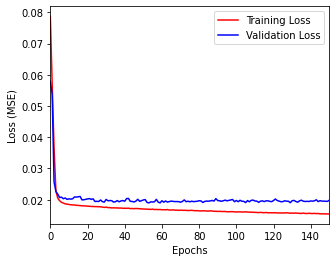

In [ ]:
epoch = np.arange(len(train_losses_plot))
plt.figure(figsize=(5, 4))
plt.plot(epoch, train_losses_plot, 'r', epoch, test_losses_plot, 'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim(0,150)
#plt.rcParams["figure.figsize"] = (3,3)

### Prediction and Validation

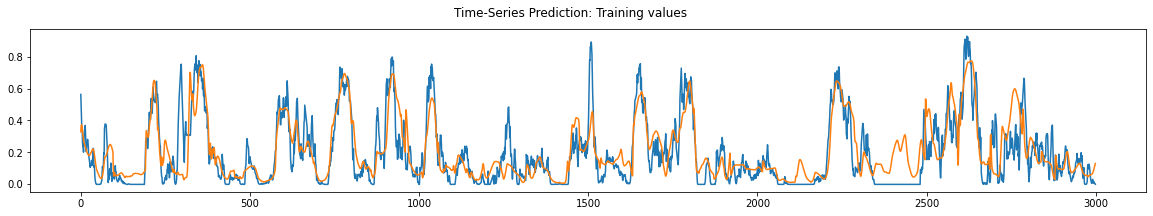

Loss:  0.015627425901754585


In [ ]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  train_predict = train_predict.cpu()

# Calculating loss of fitted training data
loss = criterion(train_predict[:,0], torch.tensor(training_set_y[:,0][seq_length_past:]))

train_predict = train_predict.data.numpy()
train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,train_predict))

# Set here the start and end index of data in order to zoom in
start_index = 2000
end_index = 5000

dataY_plot = training_set_y[start_index:end_index]
data_predict = train_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Training values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

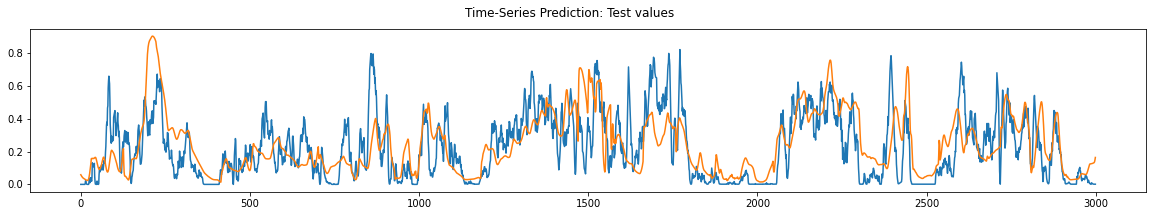

Loss:  0.020080538922791283


In [ ]:
# Plotting predicted test values

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

# Calculating loss of predicted test data
loss = criterion(test_predict[:,0], torch.tensor(test_set_y[:,0][seq_length_past:]))

test_predict = test_predict.data.numpy()
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = 12000
end_index = 15000

dataY_plot = test_set_y[start_index:end_index]
data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

plt.suptitle('Time-Series Prediction: Test values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

### Error Measurements

In [ ]:
full_set_x = np.concatenate((training_set_x,test_set_x))
full_set_y = np.concatenate((training_set_y,test_set_y))

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, full_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

In [ ]:
# Predicting test values

lstm.eval()
full_predict = lstm(trainX)
test_predict = full_predict[len(full_predict)-len(test_set_y):]
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
test_values = test_set_y

dataset_conversions = dataset_normdata_3
norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [ ]:
#Error measurements

cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)
rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  7043.718978742907
mae:  4972.260219142066
rms (normalized):  0.14229735310591732
mae (normalized):  0.10044970139680941
smape:  41.57255067946271
accuracy:  85.77026468940826


# CNN Model part

### Data importing for CNN model

In [1]:
import pandas as pd
import numpy as np
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader
from tqdm.notebook import tqdm, trange

# against matplotlib kernel dieing
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
dataPath = r'C:\Users\PC\Documents\GitHub\WindPower_Estimation'

dataset_train_1 = pd.read_csv(dataPath+'\Case1\Dataset_Train_1.csv', )
dataset_test_1 = pd.read_csv(dataPath+'\Case1\Dataset_Test_1.csv')
dataset_train_2 = pd.read_csv(dataPath+'\Case2\Dataset_Train_2.csv', )
dataset_test_2 = pd.read_csv(dataPath+'\Case2\Dataset_Test_2.csv')
dataset_train_3 = pd.read_csv(dataPath+'\Case3\Dataset_Train_3.csv', )
dataset_test_3 = pd.read_csv(dataPath+'\Case3\Dataset_Test_3.csv')

train_set_CNN_1 = dataset_train_1[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]
valid_set_CNN_1 = dataset_test_1[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]
train_set_CNN_2 = dataset_train_2[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]
valid_set_CNN_2 = dataset_test_2[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]
train_set_CNN_3 = dataset_train_3[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]
valid_set_CNN_3 = dataset_test_3[['Speed_50m', 'Direction_50m', 'Park_Power_[KW]']]

### Helper functions

In [3]:
# This function is similar to the sliding window
def split_sequence(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(data_x)-seq_length_future):
        _x = data_x[(i-seq_length_past ):(i )]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x)  ,np.array(y)
 

In [4]:
# This function is a unique data type, needed for the batch generation and data feeding for the network
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

### CNN Model parameters

In [5]:
class CNN_ForecastNet(nn.Module):
    def __init__(self, inputChannels, outputChannels, middleChannels, kernelSize1, kernelSize2, seqLength):
        super(CNN_ForecastNet,self).__init__()
        
        self.conv1d_1 = nn.Conv1d(in_channels=inputChannels, out_channels=middleChannels, kernel_size= kernelSize1 ) 
        #output: seqLength-kernelSize1+1 == 100-4+1:97
        self.batchnorm1D_conv1 = nn.BatchNorm1d( middleChannels )  #the nuber of output channels
        
        self.conv1d_2 = nn.Conv1d(in_channels=middleChannels, out_channels=outputChannels, kernel_size= kernelSize2 )
        #output: conv1_seqLength-kernelSize2+1 == 97-8+1 =90
        self.batchnorm1D_conv2 = nn.BatchNorm1d( outputChannels )  #the nuber of output channels
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d( kernel_size=2  ) #kernel size from which teh pooling is selected
        self.dropout = nn.Dropout(p=0.1)
        #output: conv2_seqLength/2 == 90/2:45
        
        self.fc1 = nn.Linear( outputChannels*( int( ((seqLength-kernelSize1+1)/1-kernelSize2+1)/2 ) ), 50)
        self.fc2 = nn.Linear(50,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.conv1d_1(x)
        x = self.batchnorm1D_conv1(x)
        x = self.relu(x)

        x = self.conv1d_2(x)
        x = self.batchnorm1D_conv2(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = x.view( x.shape[0], -1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        
        return x

### Error measurement functions

In [6]:
# Error measurement functions
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)))) * 100

def accuracy_rate(y_true, y_pred, cap):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (1 - (np.sqrt(np.mean((y_true - y_pred) ** 2))/cap)) * 100

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Case 1

In [ ]:

seq_length_past = 100
seq_length_future = 1


train_x, train_y   = split_sequence( dataset_train_1[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_train_1[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)
test_x, test_y   = split_sequence( dataset_test_1[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_test_1[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)

### Training parameters

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputChannels = 2
outputChannels = 64
middleChannels = 128
kernelSize1 = 4
kernelSize2 = 30
cnn = CNN_ForecastNet(inputChannels, outputChannels, middleChannels, kernelSize1, kernelSize2, seq_length_past).to(device)

optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [8]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = 1000

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=True)


train_losses = []
test_losses = []
def Train():
    running_loss = .0
    cnn.train()
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = torch.permute( inputs,(0,2,1) )
        inputs = inputs.to( device )
        labels = labels.to( device )
        optimizer.zero_grad()
        preds = cnn( inputs.float() )
        loss = criterion( preds,labels.float() )
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.cpu().detach().numpy())
    if( len( train_losses)%10 ==0  or  len( train_losses) ==1  ):
        print(f'train_loss {train_loss}')
    

def Valid():
    running_loss = .0
    cnn.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = torch.permute( inputs,(0,2,1) )
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = cnn(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.cpu().detach().numpy())
        
        if( len( test_losses)%10 ==0  or  len( test_losses) ==1 ):
            print(f'test_loss {test_loss}')


epochs = 50
for epoch in trange((epochs), desc='Number of epochs: '):
    Train()
    Valid()
    gc.collect()

Number of epochs:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss 0.06518038362264633
test_loss 0.05317745204375493
train_loss 0.043266937136650085
test_loss 0.04058256806211688
train_loss 0.04112524539232254
test_loss 0.04185321925729209
train_loss 0.03967895358800888
test_loss 0.04192942430061218
train_loss 0.038436226546764374
test_loss 0.04032979623980371
train_loss 0.037367526441812515
test_loss 0.039765130598246844


### Losses


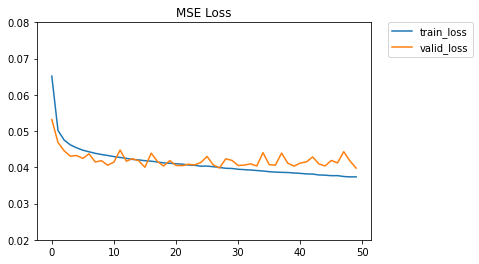

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0.02, 0.08)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Prediction of training

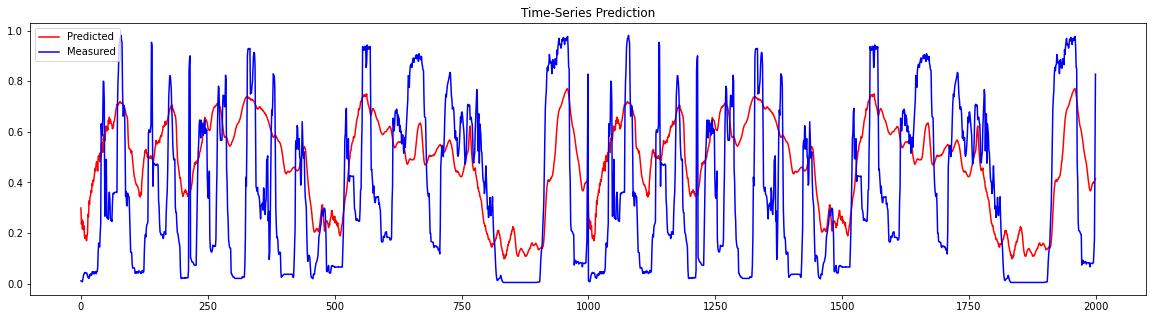

In [14]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
cnn.eval()

for i in range(2):
    inputs, labels = next( iter( train_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)


plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Prediction of testing

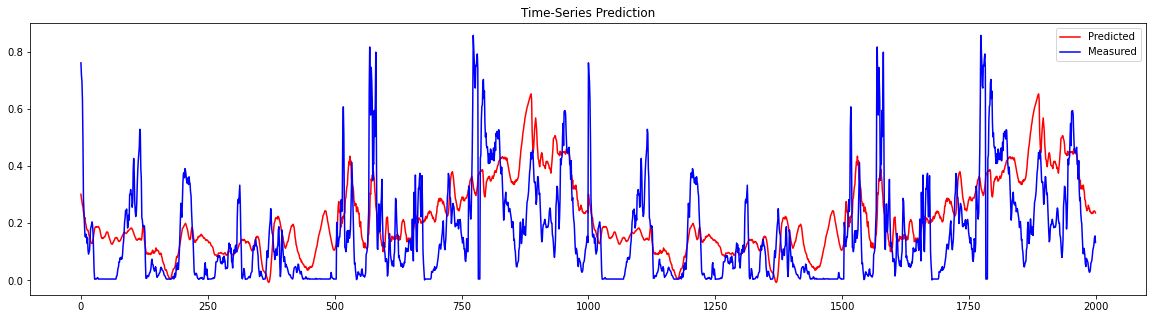

In [15]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
cnn.eval()

for i in range(2):
    inputs, labels = next( iter( test_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)


plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [17]:
# This function is a manual implementation, similar to other implementations like TimeSeriesData

def sliding_windows(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(data_x)-seq_length_future+1):
        _x = data_x[(i-seq_length_past):(i+seq_length_future)]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

### Error Measurements

In [18]:
full_set_x = np.concatenate((train_x,test_x))
full_set_y = np.concatenate((train_y,test_y))

full_set = ElecDataset( full_set_x, full_set_y)

full_set_loader = torch.utils.data.DataLoader(full_set, batch_size=batchSize, shuffle=True)

full_predict = []
target = []
cnn.eval()

for idx, (inputs, labels) in enumerate(full_set_loader):
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    full_predict.append( preds.cpu().detach().numpy() )

    
full_predict = list(np.concatenate(full_predict).flat)

In [19]:
# Predicting test values
test_predict = full_predict[len(full_predict)-len(test_y):]

test_values = test_y

dataset_conversions = pd.read_csv(dataPath+'\Case1\Dataset_NormData_1_new.csv')

norm_values_max =  dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze() 
norm_values_min =  dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze() 

multiplier = int(((norm_values_max)-(norm_values_min)) + (norm_values_min))
test_predict_real = []
test_values_real = []

for i in range( len(test_predict)):
    test_predict_real.append(test_predict[i]* multiplier)
test_predict_real= ((np.array(test_predict_real)).reshape( -1))


for i in range( len(test_values)):
    test_values_real.append(test_values[i]* multiplier)
test_values_real= ((np.array(test_values_real)).reshape( -1))


In [20]:
#Error measurements

cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)
rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  19492.391885170367
mae:  15539.554276789791
rms (normalized):  0.3937856946499064
mae (normalized):  0.3139303894300968
smape:  57.084834456190045
accuracy:  60.62143053500936


# Case 2

In [23]:
seq_length_past = 100
seq_length_future = 1

train_x, train_y   = split_sequence( dataset_train_2[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_train_2[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)
test_x, test_y   = split_sequence( dataset_test_2[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_test_2[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)

### Training parameters

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputChannels = 2
outputChannels = 64
middleChannels = 128
kernelSize1 = 4
kernelSize2 = 30
cnn = CNN_ForecastNet(inputChannels, outputChannels, middleChannels, kernelSize1, kernelSize2, seq_length_past).to(device)

optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [25]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = 1000

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=True)


train_losses = []
test_losses = []
def Train():
    running_loss = .0
    cnn.train()
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = torch.permute( inputs,(0,2,1) )
        inputs = inputs.to( device )
        labels = labels.to( device )
        optimizer.zero_grad()
        preds = cnn( inputs.float() )
        loss = criterion( preds,labels.float() )
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.cpu().detach().numpy())
    if( len( train_losses)%10 ==0  or  len( train_losses) ==1  ):
        print(f'train_loss {train_loss}')
    

def Valid():
    running_loss = .0
    cnn.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = torch.permute( inputs,(0,2,1) )
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = cnn(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.cpu().detach().numpy())
        
        if( len( test_losses)%10 ==0  or  len( test_losses) ==1 ):
            print(f'test_loss {test_loss}')


epochs = 50
for epoch in trange((epochs), desc='Number of epochs: '):
    Train()
    Valid()
    gc.collect()

Number of epochs:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss 0.050827544182538986
test_loss 0.04863283563004917
train_loss 0.036124564707279205
test_loss 0.041096550331253444
train_loss 0.03426278755068779
test_loss 0.042647712782430264
train_loss 0.03302585333585739
test_loss 0.04156950364123203
train_loss 0.031939130276441574
test_loss 0.0444302494513979
train_loss 0.031093955039978027
test_loss 0.041426862788831585


### Losses


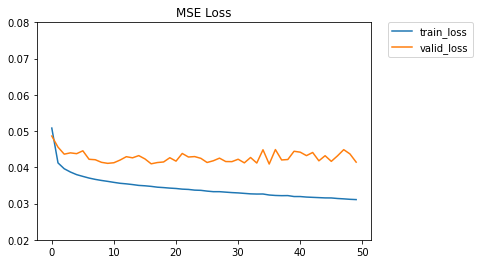

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0.02, 0.08)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Prediction of training

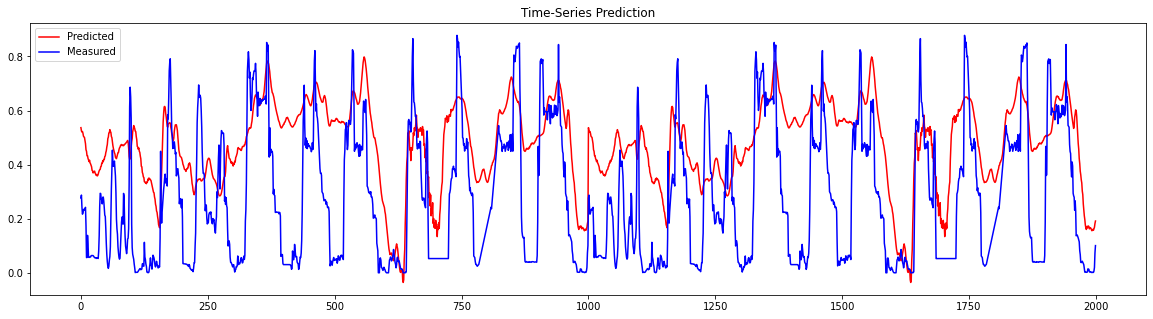

In [27]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
cnn.eval()

for i in range(2):
    inputs, labels = next( iter( train_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)


plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Prediction of testing

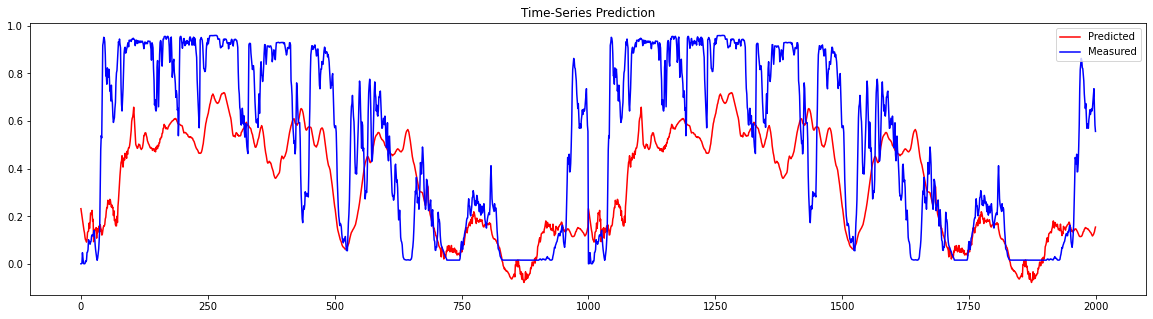

In [28]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
cnn.eval()

for i in range(2):
    inputs, labels = next( iter( test_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)


plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Error Measurements

In [30]:
full_set_x = np.concatenate((train_x,test_x))
full_set_y = np.concatenate((train_y,test_y))

full_set = ElecDataset( full_set_x, full_set_y)

full_set_loader = torch.utils.data.DataLoader(full_set, batch_size=batchSize, shuffle=True)

full_predict = []
target = []
cnn.eval()

for idx, (inputs, labels) in enumerate(full_set_loader):
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    full_predict.append( preds.cpu().detach().numpy() )

    
full_predict = list(np.concatenate(full_predict).flat)

In [31]:
# Predicting test values
test_predict = full_predict[len(full_predict)-len(test_y):]

test_values = test_y

dataset_conversions = pd.read_csv(dataPath+'\Case1\Dataset_NormData_1_new.csv')

norm_values_max =  dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze() 
norm_values_min =  dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze() 

multiplier = int(((norm_values_max)-(norm_values_min)) + (norm_values_min))
test_predict_real = []
test_values_real = []

for i in range( len(test_predict)):
    test_predict_real.append(test_predict[i]* multiplier)
test_predict_real= ((np.array(test_predict_real)).reshape( -1))


for i in range( len(test_values)):
    test_values_real.append(test_values[i]* multiplier)
test_values_real= ((np.array(test_values_real)).reshape( -1))


In [32]:
#Error measurements

cap = 99000

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)
rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  17267.676029779745
mae:  13182.028164595808
rms (normalized):  0.1744209699977752
mae (normalized):  0.13315179964238189
smape:  63.45112408775741
accuracy:  82.55790300022248


# Case 3

In [33]:
seq_length_past = 100
seq_length_future = 1

train_x, train_y   = split_sequence( dataset_train_3[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_train_3[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)
test_x, test_y   = split_sequence( dataset_test_3[['Speed_50m', 'Direction_50m']].to_numpy(), dataset_test_3[[ 'Park_Power_[KW]']].to_numpy()  , seq_length_past, seq_length_future)

### Training parameters

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputChannels = 2
outputChannels = 64
middleChannels = 128
kernelSize1 = 4
kernelSize2 = 30
cnn = CNN_ForecastNet(inputChannels, outputChannels, middleChannels, kernelSize1, kernelSize2, seq_length_past).to(device)

optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [35]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = 1000

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=True)


train_losses = []
test_losses = []
def Train():
    running_loss = .0
    cnn.train()
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = torch.permute( inputs,(0,2,1) )
        inputs = inputs.to( device )
        labels = labels.to( device )
        optimizer.zero_grad()
        preds = cnn( inputs.float() )
        loss = criterion( preds,labels.float() )
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.cpu().detach().numpy())
    if( len( train_losses)%10 ==0  or  len( train_losses) ==1  ):
        print(f'train_loss {train_loss}')
    

def Valid():
    running_loss = .0
    cnn.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = torch.permute( inputs,(0,2,1) )
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = cnn(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.cpu().detach().numpy())
        
        if( len( test_losses)%10 ==0  or  len( test_losses) ==1 ):
            print(f'test_loss {test_loss}')


epochs = 50
for epoch in trange((epochs), desc='Number of epochs: '):
    Train()
    Valid()
    gc.collect()

Number of epochs:   0%|          | 0/50 [00:00<?, ?it/s]

train_loss 0.07210653275251389
test_loss 0.04012902211693417
train_loss 0.02518898993730545
test_loss 0.03009482906125584
train_loss 0.023122573271393776
test_loss 0.028167835064637926
train_loss 0.02193589322268963
test_loss 0.028762731790453397
train_loss 0.02101755514740944
test_loss 0.030721562016301558
train_loss 0.02025296725332737
test_loss 0.028280164488688104


### Losses


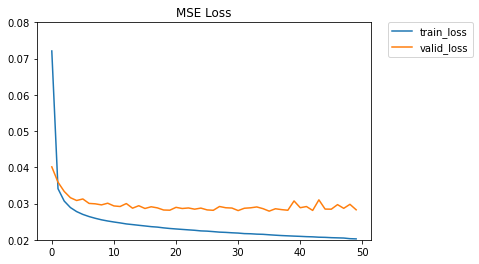

In [36]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0.02, 0.08)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Prediction of training

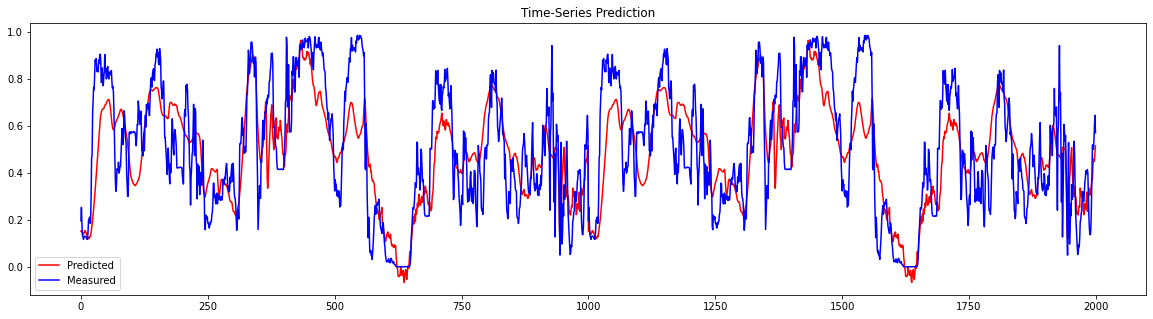

In [37]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
cnn.eval()

for i in range(2):
    inputs, labels = next( iter( train_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)


plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Prediction of testing

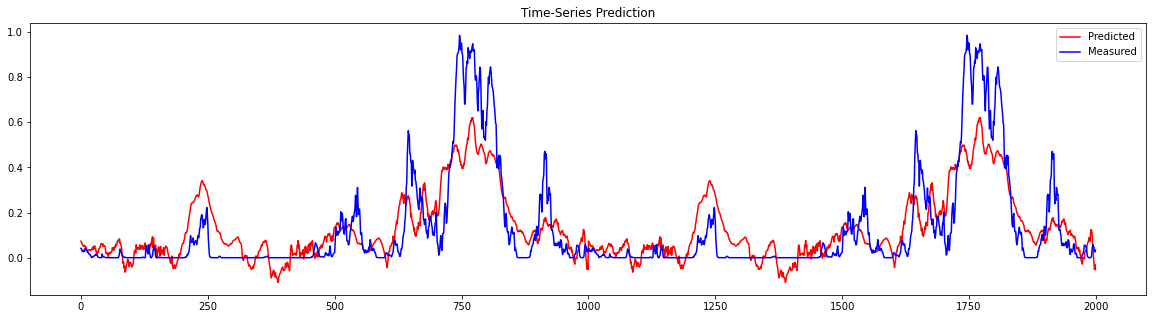

In [38]:
train = ElecDataset( train_x, train_y)
test = ElecDataset( test_x, test_y)
batchSize = batchSize

train_loader = torch.utils.data.DataLoader(train, batch_size=batchSize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batchSize, shuffle=False)
prediction = []
target = []
cnn.eval()

for i in range(2):
    inputs, labels = next( iter( test_loader))
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    prediction.append( preds.cpu().detach().numpy() )
    target.append( labels.cpu().detach().numpy() )
    
prediction = list(np.concatenate(prediction).flat)
target = list(np.concatenate(target).flat)


plt.figure(figsize=(20, 5))
plt.plot(prediction, color = 'r', label='Predicted') 
plt.plot(target, color = 'b', label='Measured') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Error Measurements

In [40]:
full_set_x = np.concatenate((train_x,test_x))
full_set_y = np.concatenate((train_y,test_y))

full_set = ElecDataset( full_set_x, full_set_y)

full_set_loader = torch.utils.data.DataLoader(full_set, batch_size=batchSize, shuffle=True)

full_predict = []
target = []
cnn.eval()

for idx, (inputs, labels) in enumerate(full_set_loader):
    inputs = torch.permute( inputs,(0,2,1) )
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    preds = cnn(inputs.float())
    full_predict.append( preds.cpu().detach().numpy() )

    
full_predict = list(np.concatenate(full_predict).flat)

In [41]:
# Predicting test values
test_predict = full_predict[len(full_predict)-len(test_y):]

test_values = test_y

dataset_conversions = pd.read_csv(dataPath+'\Case1\Dataset_NormData_1_new.csv')

norm_values_max =  dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze() 
norm_values_min =  dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze() 

multiplier = int(((norm_values_max)-(norm_values_min)) + (norm_values_min))
test_predict_real = []
test_values_real = []

for i in range( len(test_predict)):
    test_predict_real.append(test_predict[i]* multiplier)
test_predict_real= ((np.array(test_predict_real)).reshape( -1))


for i in range( len(test_values)):
    test_values_real.append(test_values[i]* multiplier)
test_values_real= ((np.array(test_values_real)).reshape( -1))


In [42]:
#Error measurements

cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)
rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  15541.896747426641
mae:  11801.766102948577
rms (normalized):  0.3139777120692251
mae (normalized):  0.23841951723128438
smape:  60.889521511947365
accuracy:  68.60222879307749
